### RISHU RAJ SINGH (2023AIB2080)

In [1]:
import pandas as pd
import numpy as np
import torch
import math
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Loading data
data = pd.read_csv("NETFLIX_data.csv")
data.columns

Index(['Date', 'High', 'Low', 'Close'], dtype='object')

In [3]:
data.head()

Date        High         Low       Close
0  19-03-2020  348.510010  316.820007  332.029999
1  20-03-2020  350.489990  332.000000  332.829987
2  23-03-2020  366.109985  340.880005  360.269989
3  24-03-2020  372.929993  353.029999  357.320007
4  25-03-2020  362.000000  339.170013  342.390015

In [4]:
# Droping Date column
data.drop(['Date'],axis=1,inplace=True)

# Normalization
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data = (data - mean)/std


In [5]:
# Training_data (600) + validation_data (100) = 700 

train_data = data[:600]
val_data = data[600:700]
test_data = data[700:]

seq_length=3

def create_dataset(data, steps):
    X, y = [], []
    for i in range(len(data) - steps - 1):
        X.append(data.iloc[i:(i + steps), :])
        y.append(data.iloc[i + steps, :])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, seq_length)
X_val, y_val = create_dataset(val_data, seq_length)
X_test, y_test = create_dataset(test_data, seq_length)

In [6]:
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)


train = torch.utils.data.TensorDataset(X_train,y_train)
val = torch.utils.data.TensorDataset(X_val,y_val)
test = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=1, 
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val, 
                                           batch_size=1, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=1, 
                                          shuffle=False)

In [7]:
def training_loop(num_epochs,lr,model):

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = num_epochs
    Loss = []
    total_loss = 0
    y_pred = []
    for t in range(num_epochs):
        for inputs,targets in train_loader:
            y_train_pred = model(inputs.float())
            loss = loss_fn(y_train_pred, targets.float())
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (t+1)%num_epochs == 0:
            for inputs, targets in val_loader:        
                y_val_pred = model(inputs.float())
                y_pred.append(y_val_pred)

        if (t+1) % 1 == 0:
            print("Epoch ", t+1, "MSE: ", total_loss/len(train_loader))
            Loss.append(total_loss/len(train_loader))
            total_loss = 0
            
    # Denormalization of data        
    high_p = []
    low_p = []
    close_p = []
    for i in y_pred:
        high_p.append(i[0][0].item()*std[0] + mean[0])
        low_p.append(i[0][1].item()*std[1] + mean[1])
        close_p.append(i[0][2].item()*std[2] + mean[2])

    high_a = []
    low_a = []
    close_a = []
    for i in y_val:
        high_a.append(i[0].item()*std[0] + mean[0])
        low_a.append(i[1].item()*std[1] + mean[1])
        close_a.append(i[2].item()*std[2] + mean[2])  
        
        
    # plots        
    fig, axs = plt.subplots(1,1, figsize=(20, 6))

    axs.plot(Loss, label='Training Loss')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Values')
    axs.set_title('Training Loss')
    axs.legend()
    axs.grid(True)

    fig, axs = plt.subplots(1,1, figsize=(20, 6))
    # Plot High Prices
    axs.plot(high_p, label='Predicted')
    axs.plot(high_a, label='Actual')
    axs.set_xlabel('Numer_of_timestamps')
    axs.set_ylabel('Values')
    axs.set_title('High Prices_valiadation_set')
    axs.legend()
    axs.grid(True)

    fig, axs = plt.subplots(1,1, figsize=(20, 6))
    # Plot Low Prices
    axs.plot(low_p, label='Predicted')
    axs.plot(low_a, label='Actual')
    axs.set_xlabel('Numer_of_timestamps')
    axs.set_ylabel('Values')
    axs.set_title('Low Prices_valiadation_set')
    axs.legend()
    axs.grid(True)

    fig, axs = plt.subplots(1, 1, figsize=(20, 6))
    # Plot Close Prices
    axs.plot(close_p, label='Predicted')
    axs.plot(close_a, label='Actual')
    axs.set_xlabel('Numer_of_timestamps')
    axs.set_ylabel('Values')
    axs.set_title('Close Prices_valiadation_set')
    axs.legend()
    axs.grid(True)

    plt.tight_layout()
    plt.show()    

    # Testing model
    y_pred = []

    for inputs, targets in test_loader:        
        y_test_pred = model(inputs.float())
        y_pred.append(y_test_pred)

    high_p = []
    low_p = []
    close_p = []
    for i in y_pred:
        high_p.append(i[0][0].item()*std[0] + mean[0])
        low_p.append(i[0][1].item()*std[1] + mean[1])
        close_p.append(i[0][2].item()*std[2] + mean[2])

    high_a = []
    low_a = []
    close_a = []
    for i in y_test:
        high_a.append(i[0].item()*std[0] + mean[0])
        low_a.append(i[1].item()*std[1] + mean[1])
        close_a.append(i[2].item()*std[2] + mean[2]) 

    fig, axs = plt.subplots(1, 1, figsize=(20, 6))
    # Plot High Prices
    axs.plot(high_p, label='Predicted')
    axs.plot(high_a, label='Actual')
    axs.set_xlabel('Numer_of_timestamps')
    axs.set_ylabel('Values')
    axs.set_title('High Prices_test_set')
    axs.legend()
    axs.grid(True)

    fig, axs = plt.subplots(1, 1, figsize=(20, 6))
    # Plot Low Prices
    axs.plot(low_p, label='Predicted')
    axs.plot(low_a, label='Actual')
    axs.set_xlabel('Numer_of_timestamps')
    axs.set_ylabel('Values')
    axs.set_title('Low Prices_test_set')
    axs.legend()
    axs.grid(True)

    fig, axs = plt.subplots(1, 1, figsize=(20, 6))
    # Plot Close Prices
    axs.plot(close_p, label='Predicted')
    axs.plot(close_a, label='Actual')
    axs.set_xlabel('Numer_of_timestamps')
    axs.set_ylabel('Values')
    axs.set_title('Close Prices_test_set')
    axs.legend()
    axs.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
# Hyperparameters

input_dim = 3
hidden_dim = 32
num_layers = 2
output_dim = 3
num_epochs = 30
lr_1 = 0.005
lr_2 = 0.001 

### RNN

In [9]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.W_xh = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b = nn.Parameter(torch.Tensor(hidden_dim))
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        h = torch.zeros(x.size(0), self.hidden_dim).to(x.device)

        for i in range(x.size(1)):
            h = torch.tanh(torch.matmul(x[:, i, :], self.W_xh) + torch.matmul(h, self.W_hh) + self.b)

        out = self.fc(h)
        return out

Configuration 1
Epoch  1 MSE:  0.03798087399075747
Epoch  2 MSE:  0.0513305183663492
Epoch  3 MSE:  0.05476607364028881
Epoch  4 MSE:  0.050740111256061864
Epoch  5 MSE:  0.05598110950333478
Epoch  6 MSE:  0.056059438788095016
Epoch  7 MSE:  0.05511045758273072
Epoch  8 MSE:  0.05604260233147386
Epoch  9 MSE:  0.05341396782561739
Epoch  10 MSE:  0.05221154925216344
Epoch  11 MSE:  0.05229419678563019
Epoch  12 MSE:  0.05294629443719012
Epoch  13 MSE:  0.05400661652191462
Epoch  14 MSE:  0.05449312471622969
Epoch  15 MSE:  0.054114731480639965
Epoch  16 MSE:  0.05307248482334662
Epoch  17 MSE:  0.052365845998829416
Epoch  18 MSE:  0.05345061629854807
Epoch  19 MSE:  0.05307530510336869
Epoch  20 MSE:  0.05320363143357783
Epoch  21 MSE:  0.052472447620180024
Epoch  22 MSE:  0.053147666362313876
Epoch  23 MSE:  0.05307201114874566
Epoch  24 MSE:  0.053161823765720255
Epoch  25 MSE:  0.053165867908954154
Epoch  26 MSE:  0.05316820658651138
Epoch  27 MSE:  0.05321455909478078
Epoch  28 MSE:

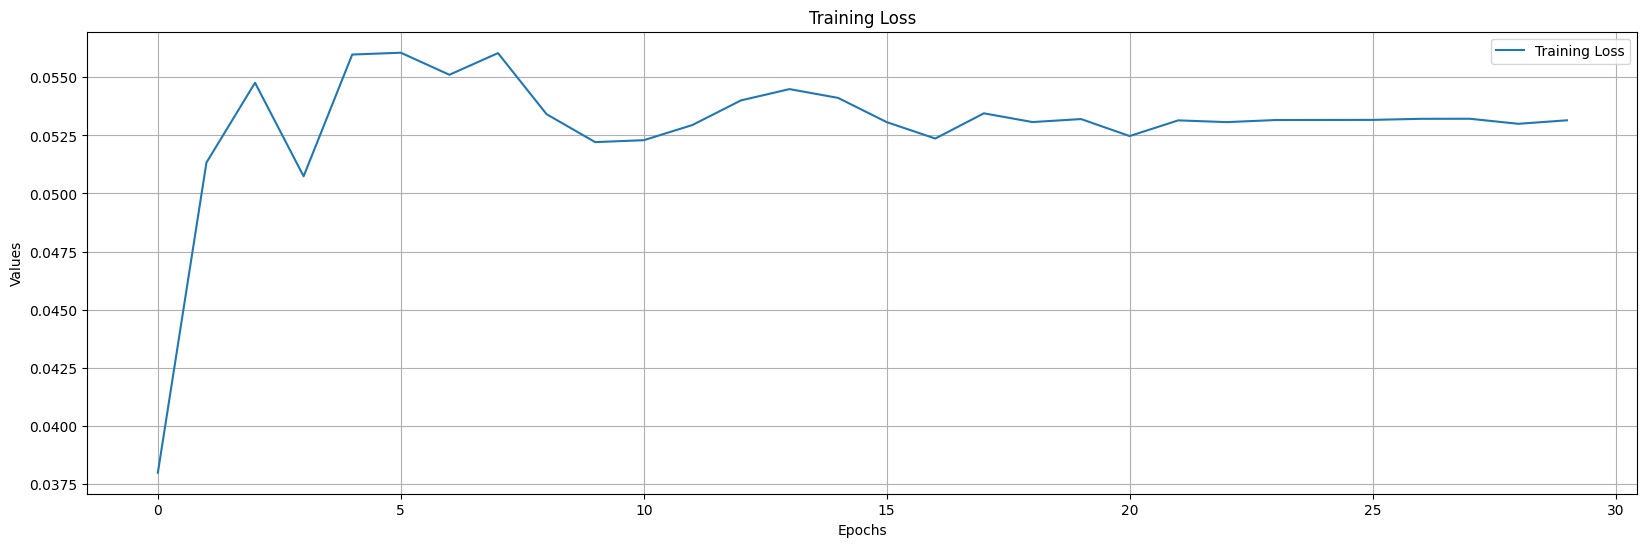

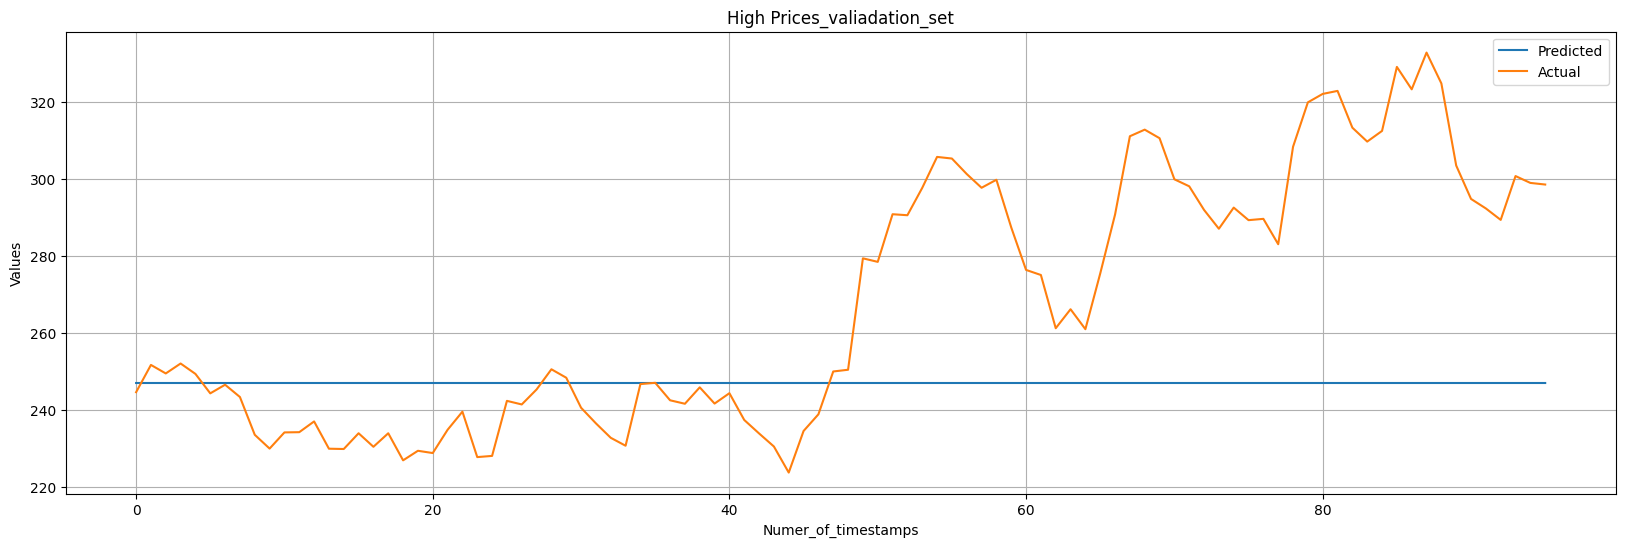

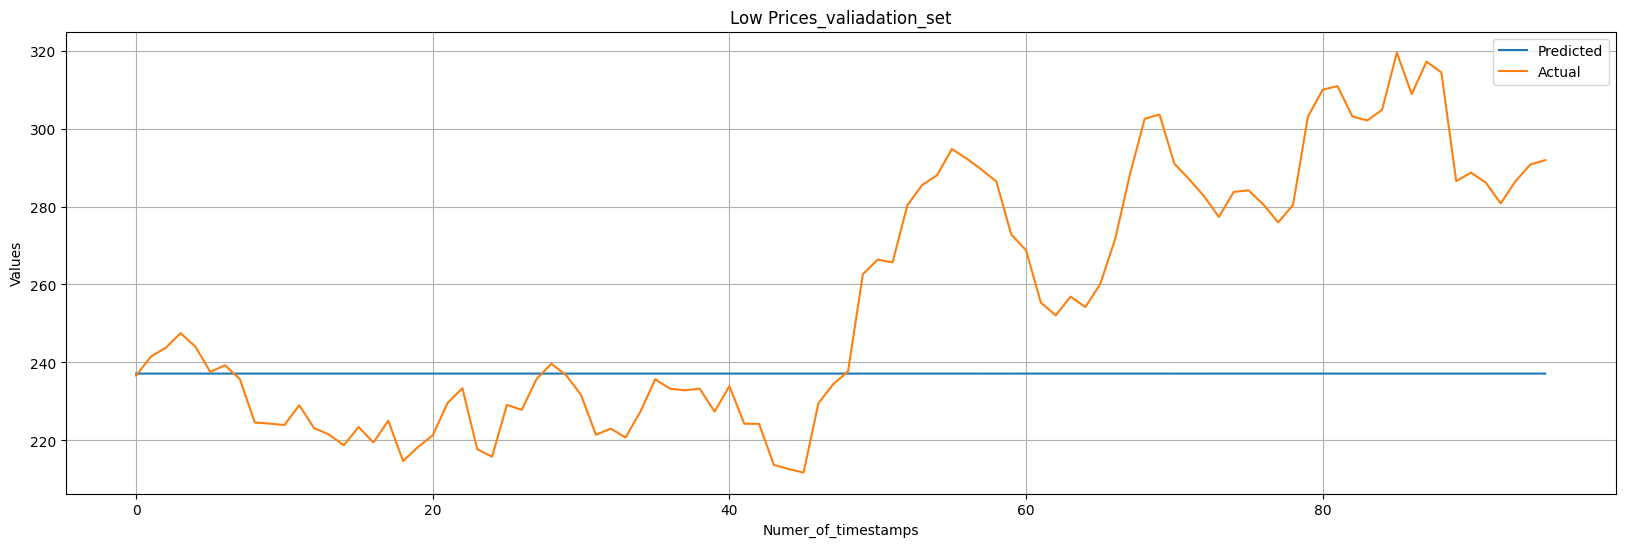

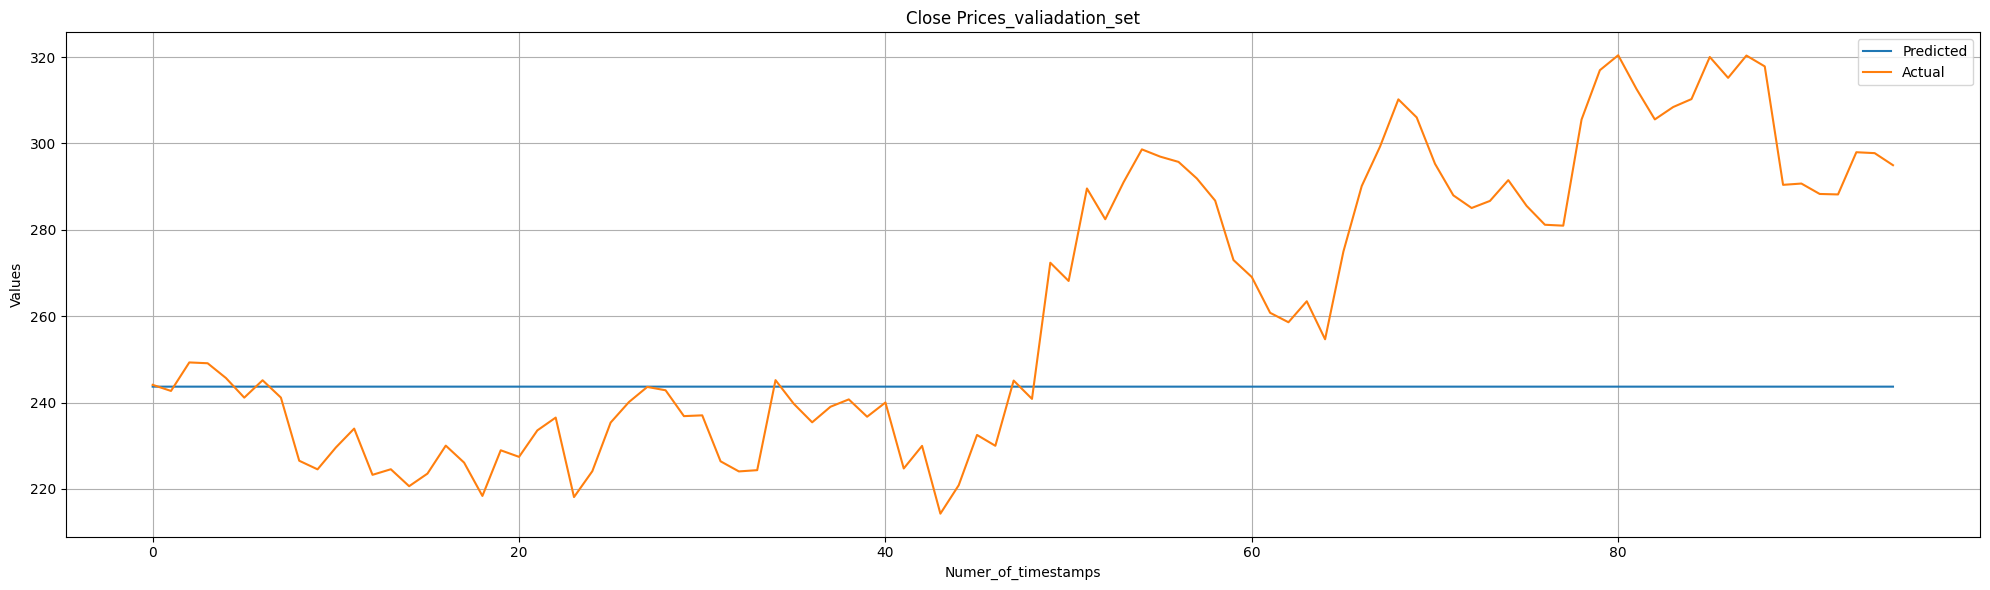

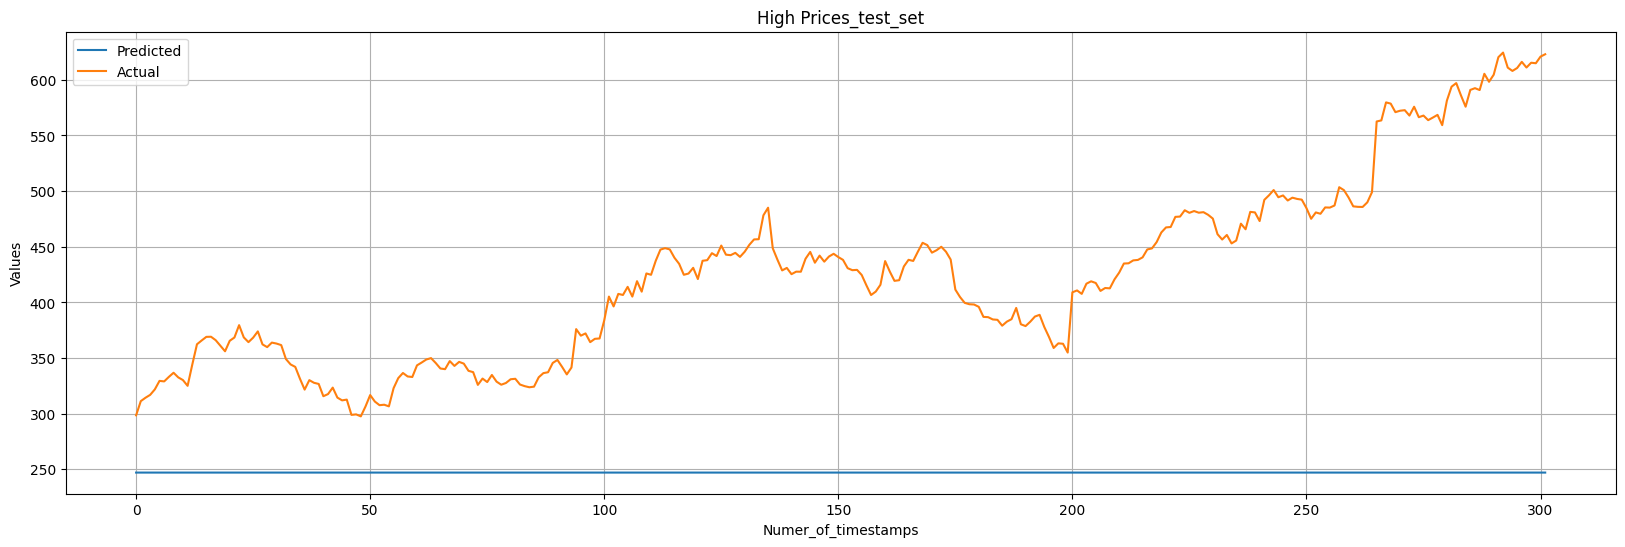

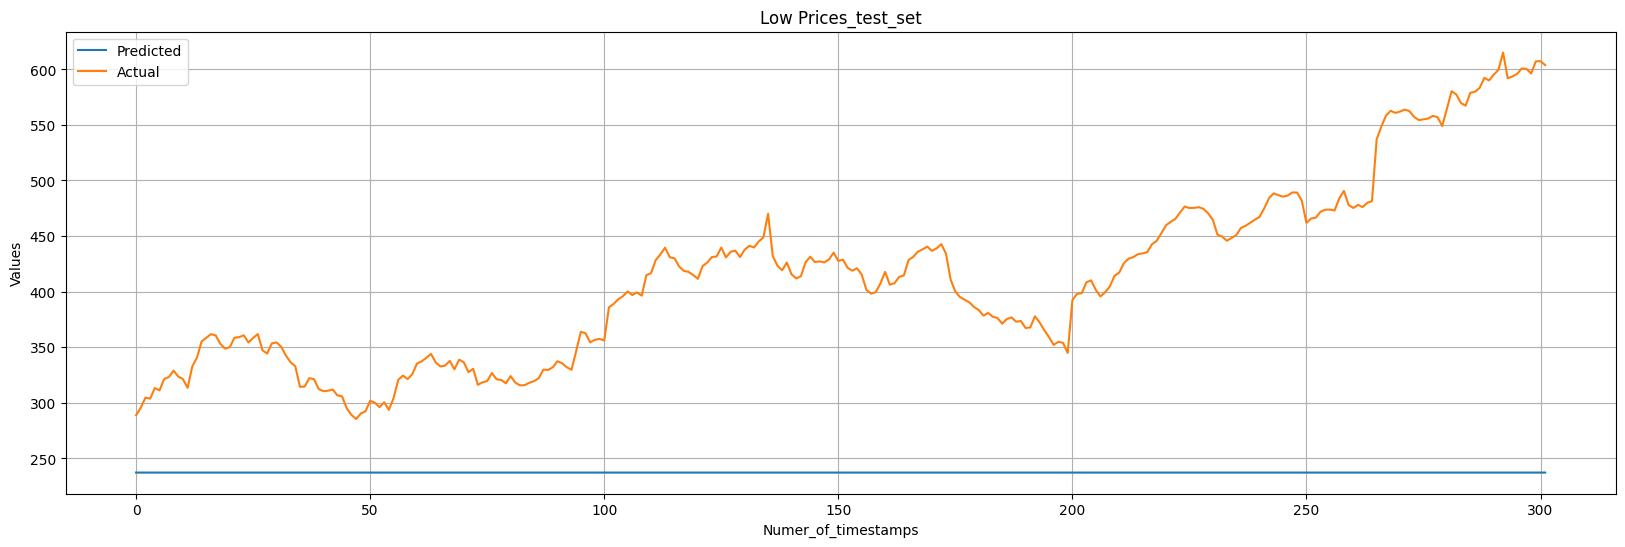

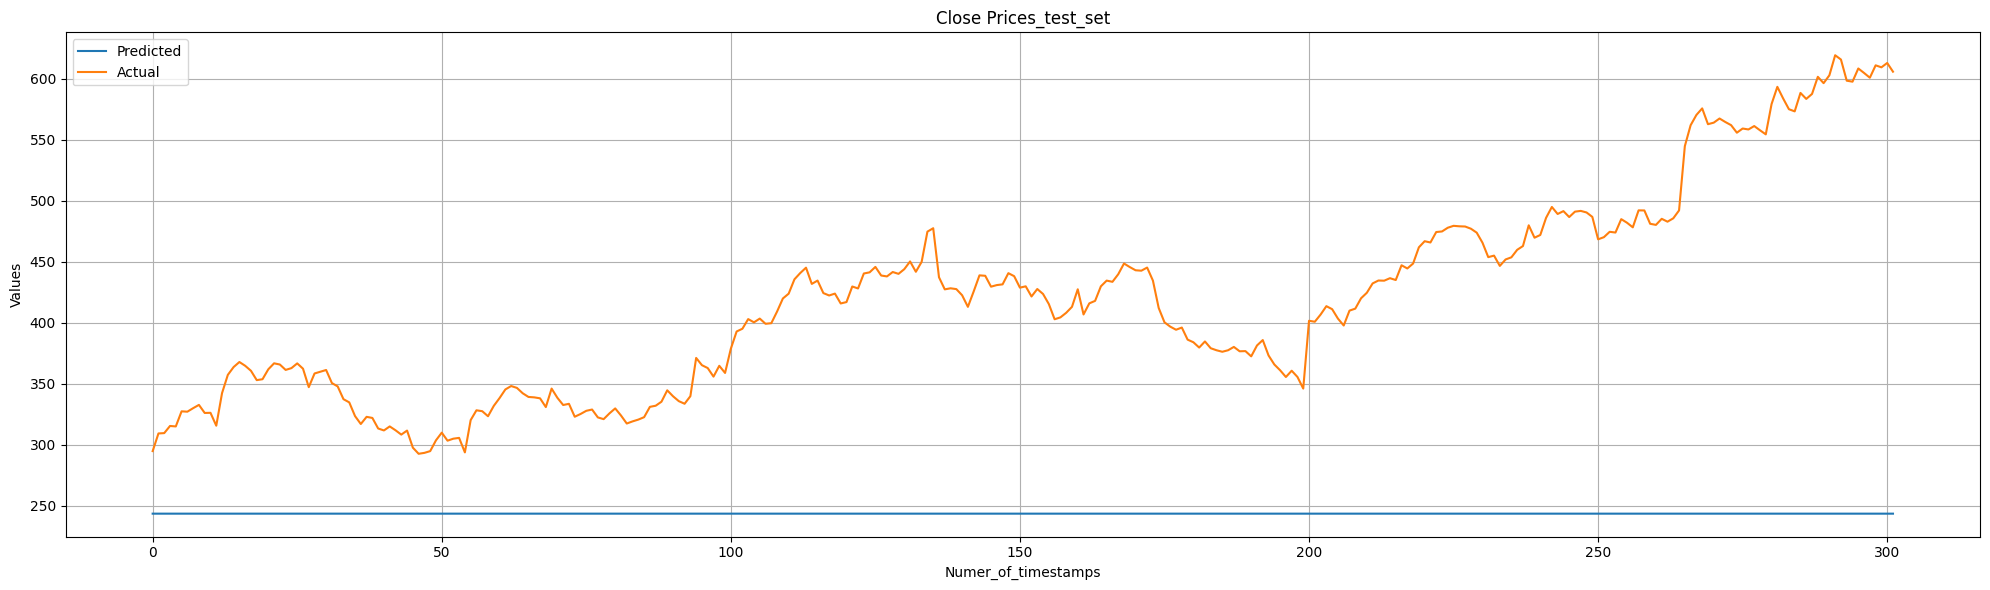

In [10]:
model_rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Congiguration 1
print("Configuration 1")
training_loop(num_epochs,lr_1,model_rnn)

Configuration 2
Epoch  1 MSE:  0.12907758946275008
Epoch  2 MSE:  0.12910157725197843
Epoch  3 MSE:  0.12871126024998716
Epoch  4 MSE:  0.12330436298019617
Epoch  5 MSE:  0.11881597814198473
Epoch  6 MSE:  0.11402687848878132
Epoch  7 MSE:  0.11503139739366303
Epoch  8 MSE:  0.10944051987554615
Epoch  9 MSE:  0.10726605347847133
Epoch  10 MSE:  0.10301448660939302
Epoch  11 MSE:  0.1021276344044414
Epoch  12 MSE:  0.09924563582996335
Epoch  13 MSE:  0.0925925693358197
Epoch  14 MSE:  0.05814789322684857
Epoch  15 MSE:  0.05716802256530789
Epoch  16 MSE:  0.04911858280632827
Epoch  17 MSE:  0.04472733131882669
Epoch  18 MSE:  0.042162839485898676
Epoch  19 MSE:  0.041233154082464044
Epoch  20 MSE:  0.042019966617782976
Epoch  21 MSE:  0.041217940631170694
Epoch  22 MSE:  0.04077846342663741
Epoch  23 MSE:  0.0399619476182631
Epoch  24 MSE:  0.03932908065873269
Epoch  25 MSE:  0.039499599089765906
Epoch  26 MSE:  0.039339127080431
Epoch  27 MSE:  0.037526119151555536
Epoch  28 MSE:  0.03

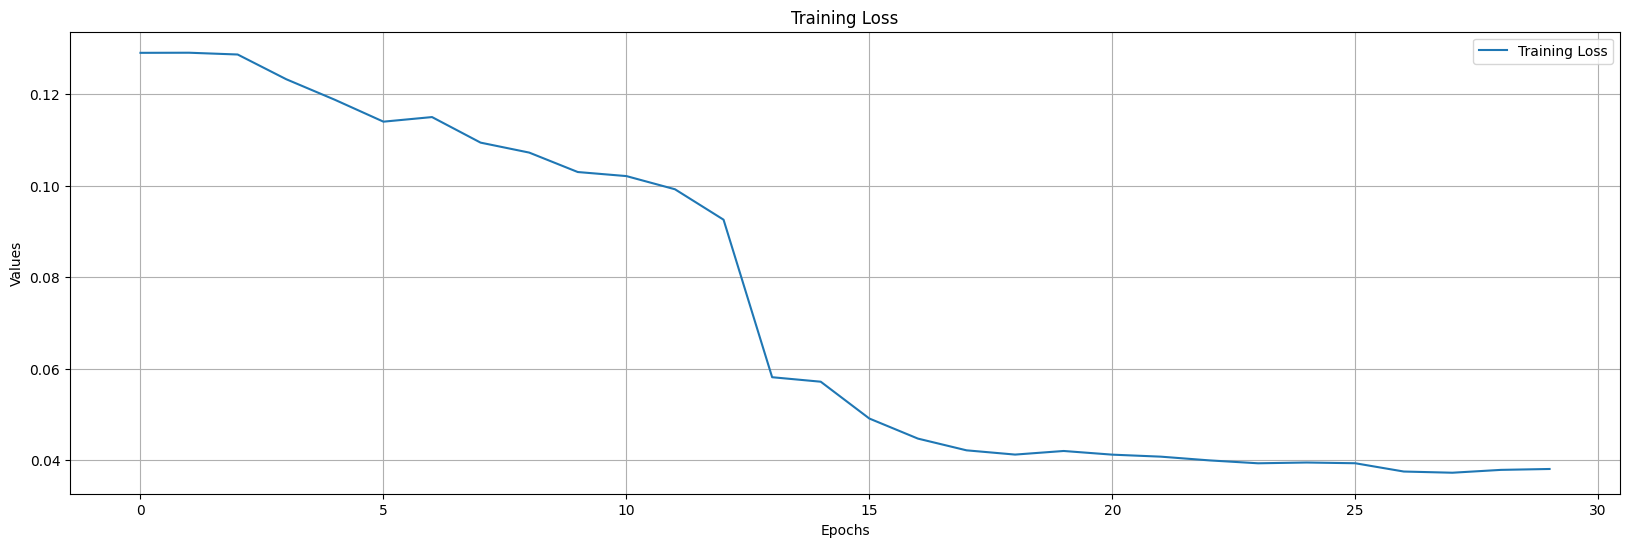

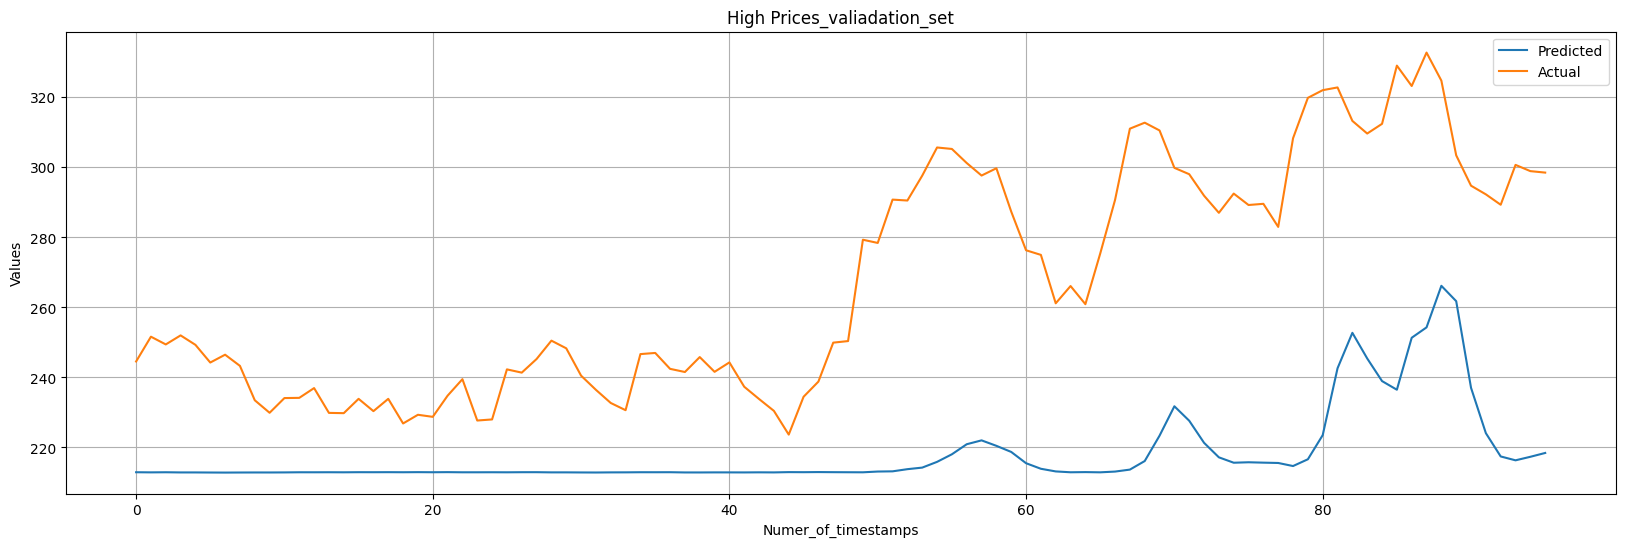

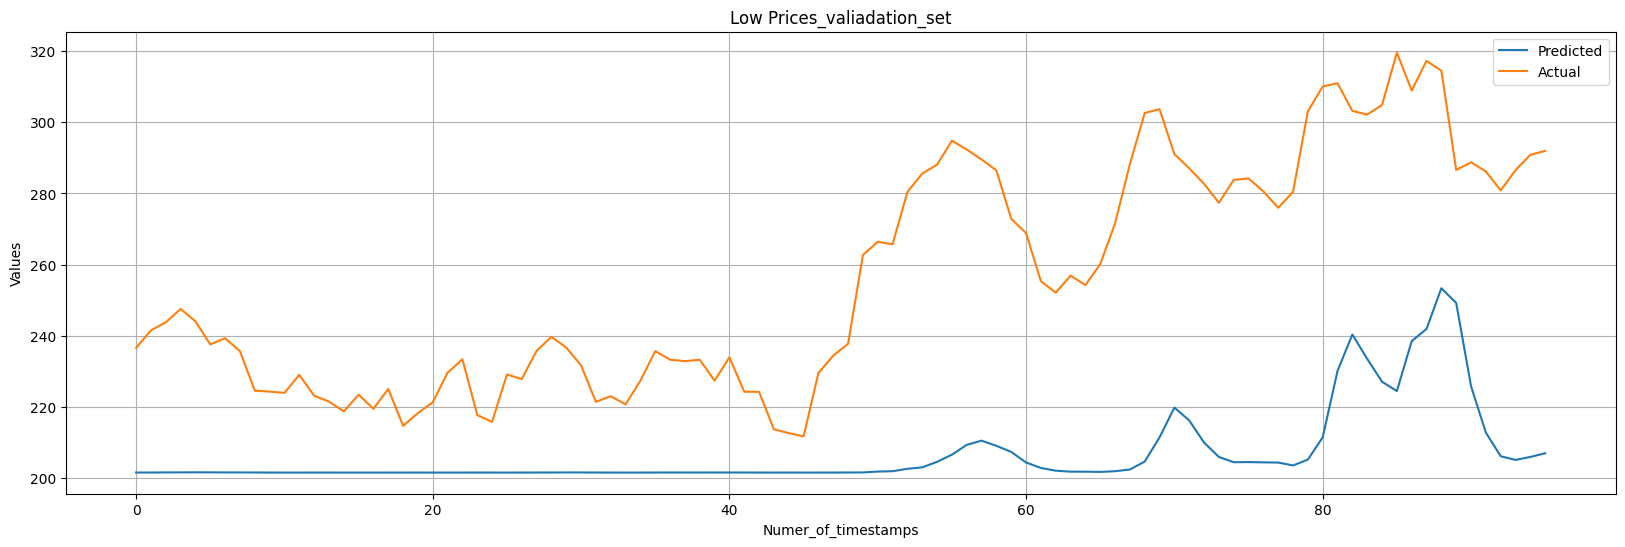

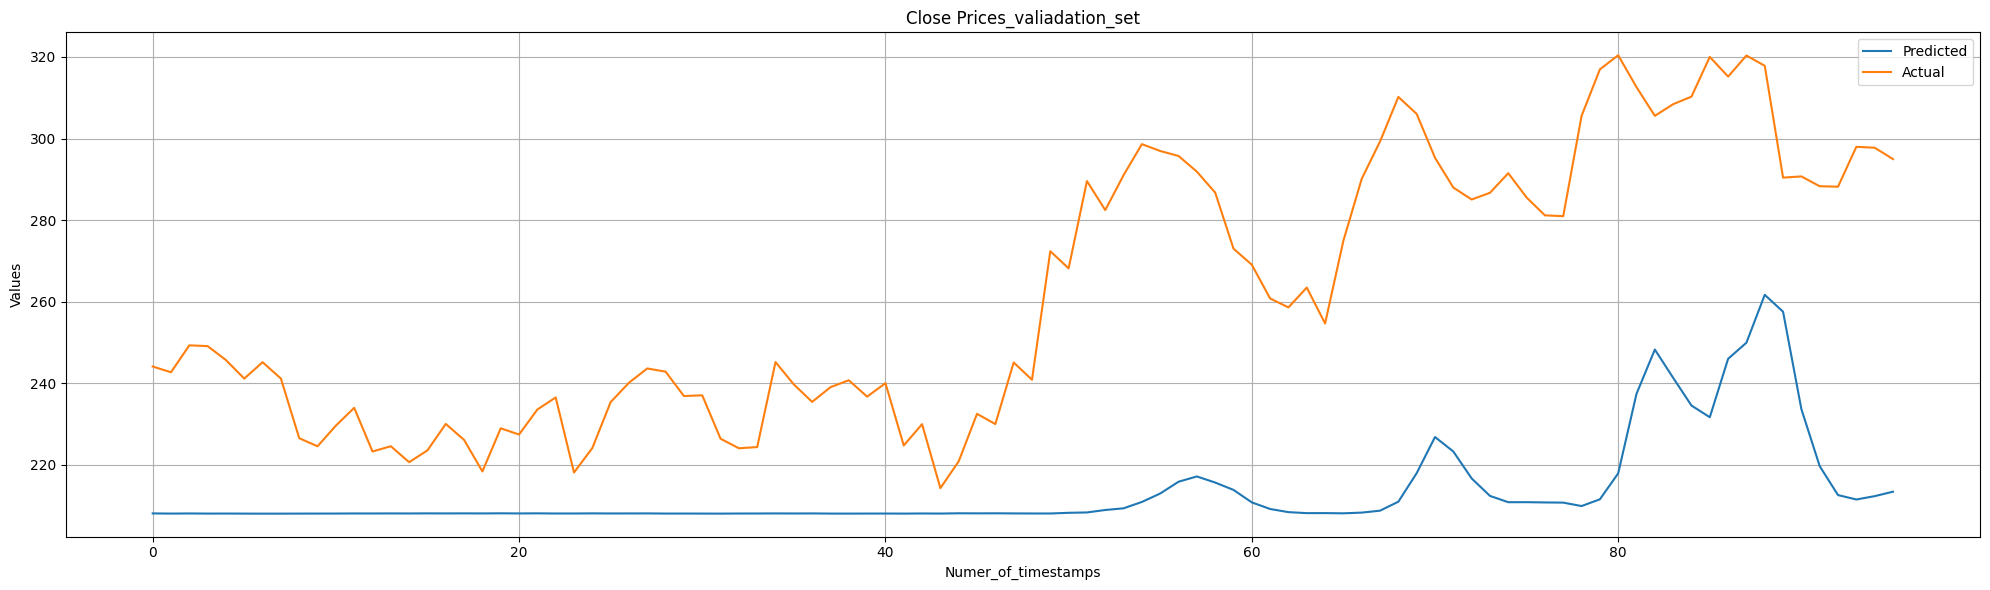

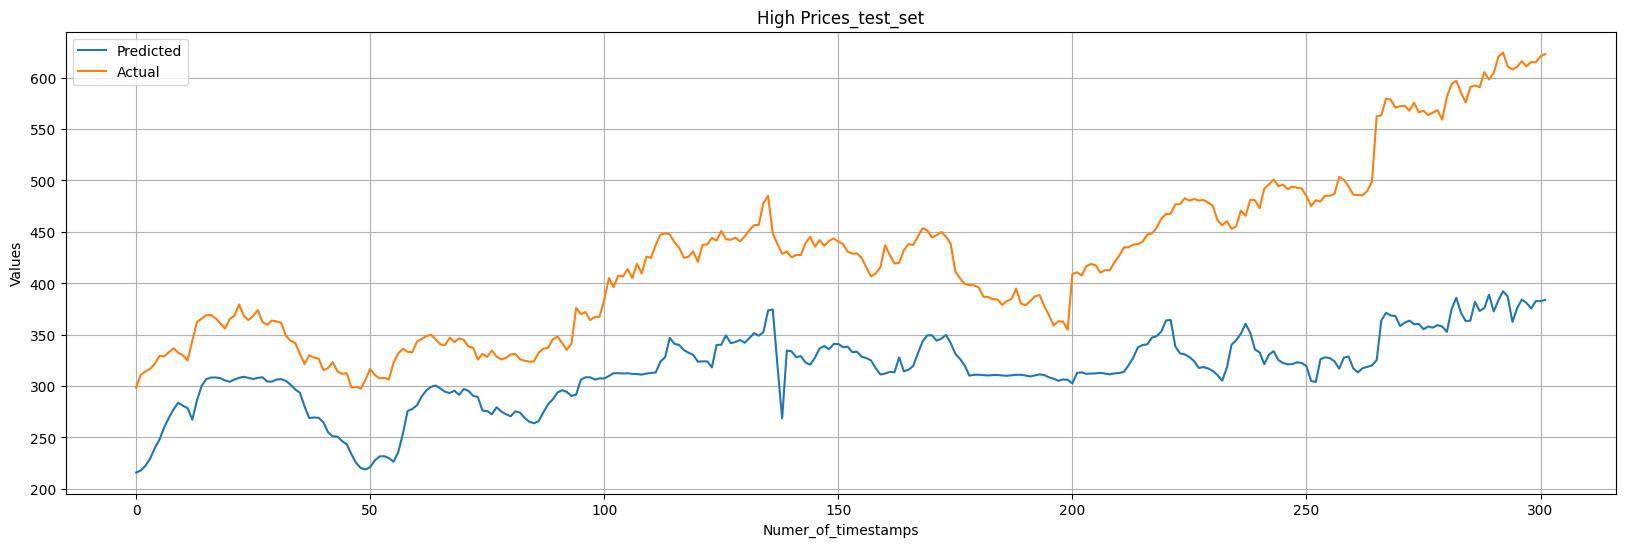

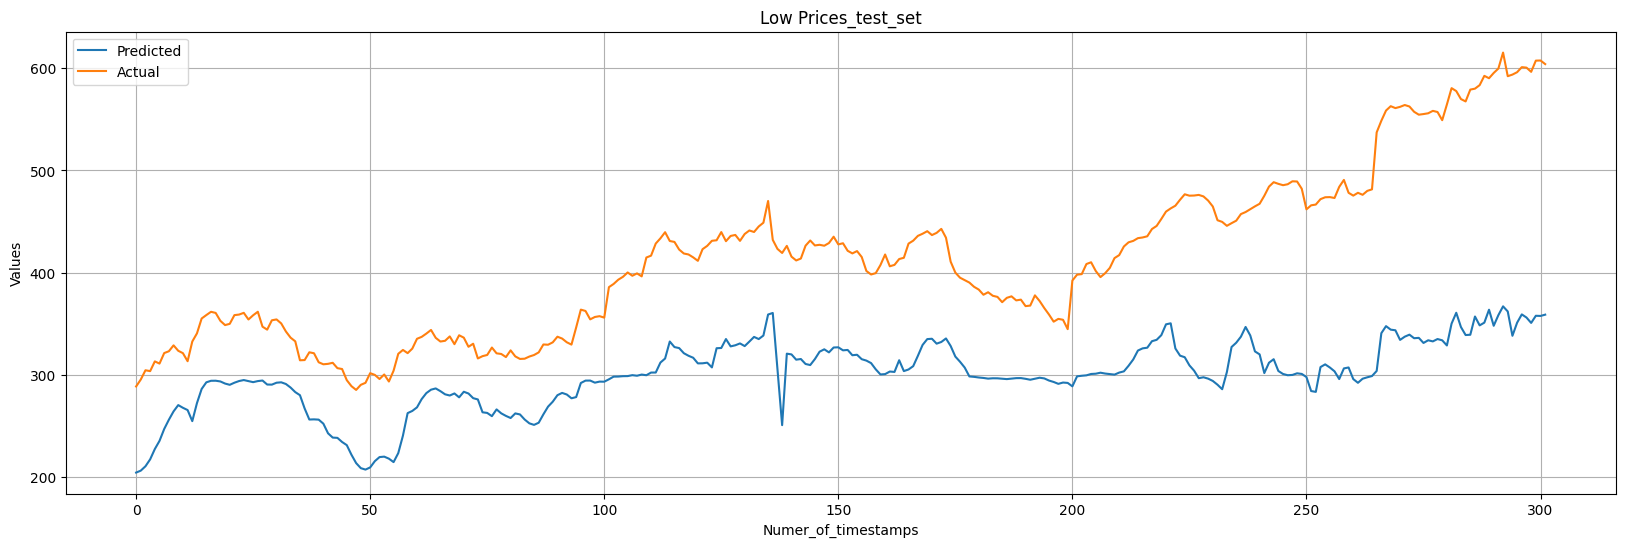

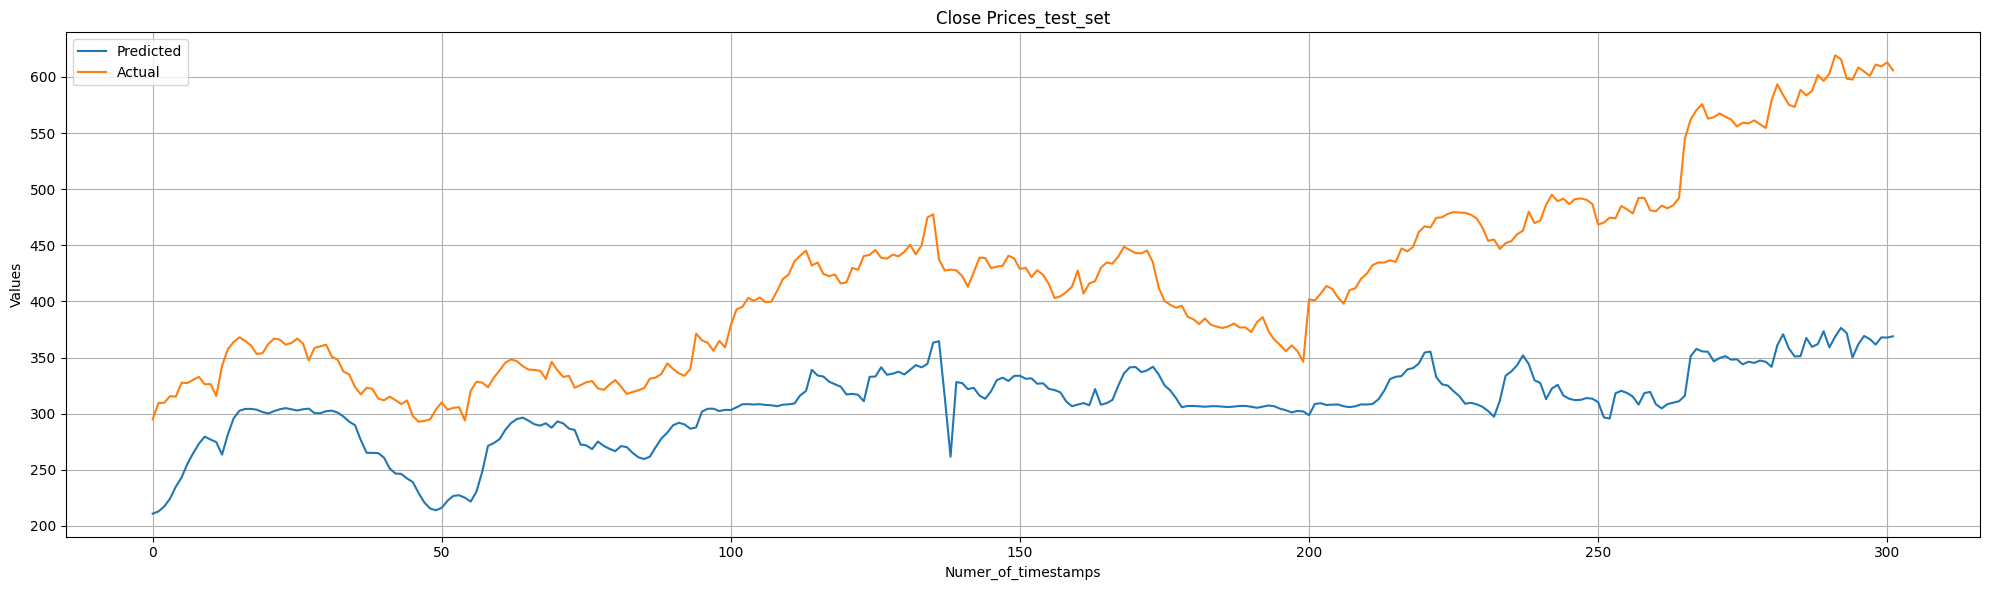

In [11]:
# Congiguration 2
print("Configuration 2")
training_loop(num_epochs,lr_2,model_rnn)

### GRU

In [12]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.W_ir = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hr = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_r = nn.Parameter(torch.Tensor(hidden_dim))

        self.W_iz = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hz = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_z = nn.Parameter(torch.Tensor(hidden_dim))

        self.W_in = nn.Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hn = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_n = nn.Parameter(torch.Tensor(hidden_dim))

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Initialize hidden state
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Iterate through time steps
        for i in range(x.size(1)):
            # GRU equations
            reset_gate = torch.sigmoid(torch.matmul(x[:, i, :], self.W_ir) + torch.matmul(h[-1, :, :], self.W_hr) + self.b_r)
            update_gate = torch.sigmoid(torch.matmul(x[:, i, :], self.W_iz) + torch.matmul(h[-1, :, :], self.W_hz) + self.b_z)
            new_candidate = torch.tanh(torch.matmul(x[:, i, :], self.W_in) + reset_gate * torch.matmul(h[-1, :, :], self.W_hn) + self.b_n)
            h = update_gate * h + (1 - update_gate) * new_candidate

        # Taking only the output from the last time step
        out = self.fc(h[-1])
        return out

Configuration 1
Epoch  1 MSE:  0.032193093779549584
Epoch  2 MSE:  0.0393254025931531
Epoch  3 MSE:  0.03862108501577294
Epoch  4 MSE:  0.03580361557427958
Epoch  5 MSE:  0.032686178038166085
Epoch  6 MSE:  0.03196186748717436
Epoch  7 MSE:  0.03023333954654497
Epoch  8 MSE:  0.03403462132473273
Epoch  9 MSE:  0.03582098678621364
Epoch  10 MSE:  0.030033037931376908
Epoch  11 MSE:  0.032232745312279154
Epoch  12 MSE:  0.03197831533567607
Epoch  13 MSE:  0.032841547573788
Epoch  14 MSE:  0.02968615155293185
Epoch  15 MSE:  0.03003697556056715
Epoch  16 MSE:  0.030632347969488872
Epoch  17 MSE:  0.028675624187883005
Epoch  18 MSE:  0.030215832602174024
Epoch  19 MSE:  0.029259260476059073
Epoch  20 MSE:  0.029151744761793757
Epoch  21 MSE:  0.029312921807736193
Epoch  22 MSE:  0.027636312498987767
Epoch  23 MSE:  0.02934246908136397
Epoch  24 MSE:  0.029088705208302153
Epoch  25 MSE:  0.027664524385301665
Epoch  26 MSE:  0.02456009837543884
Epoch  27 MSE:  0.026895740171279544
Epoch  28 

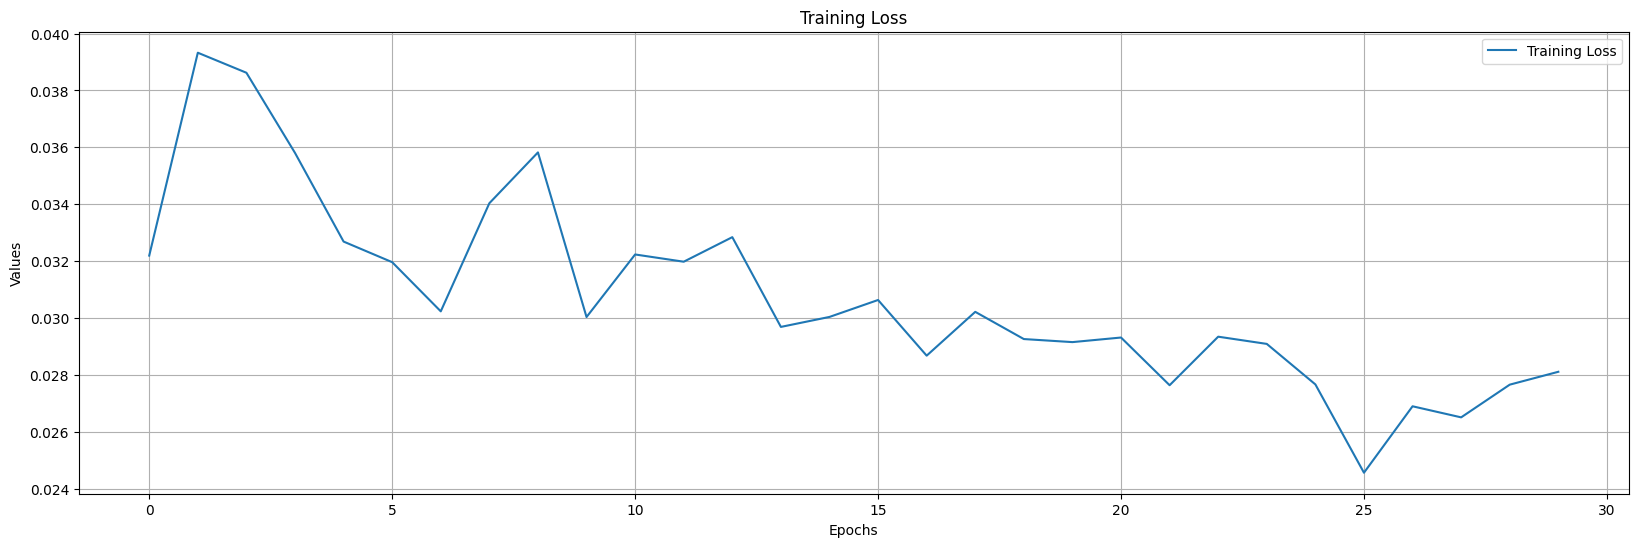

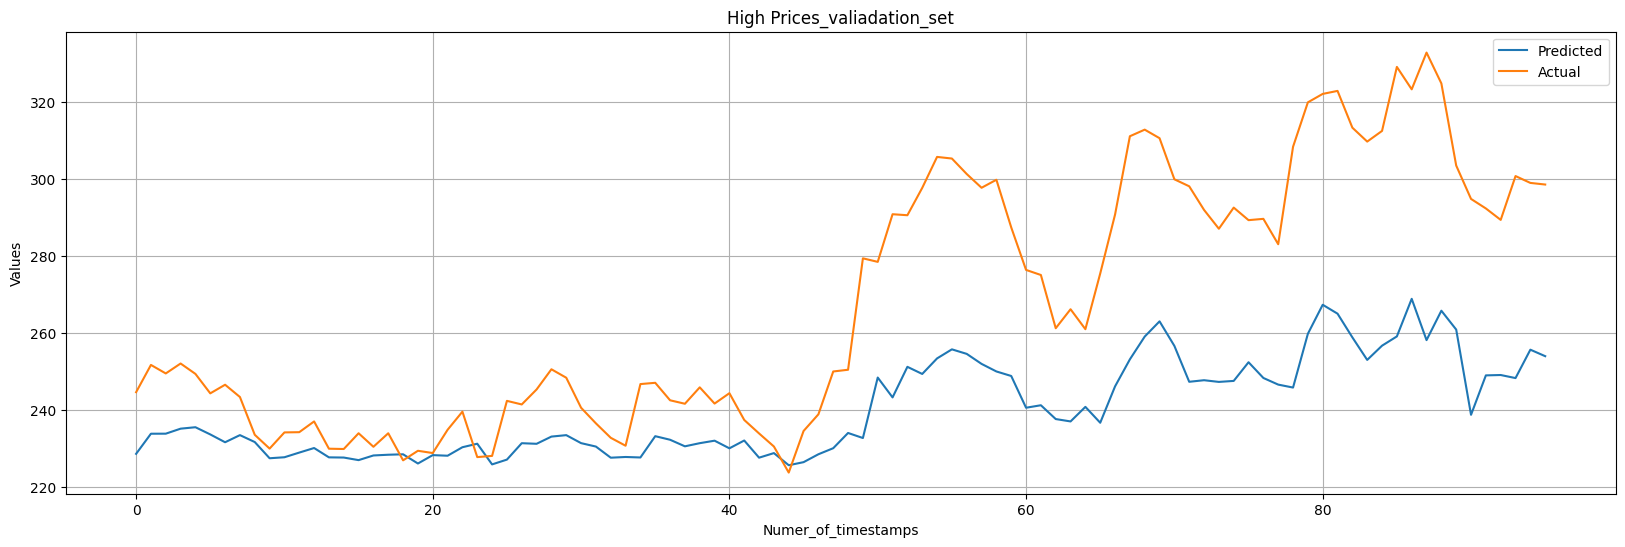

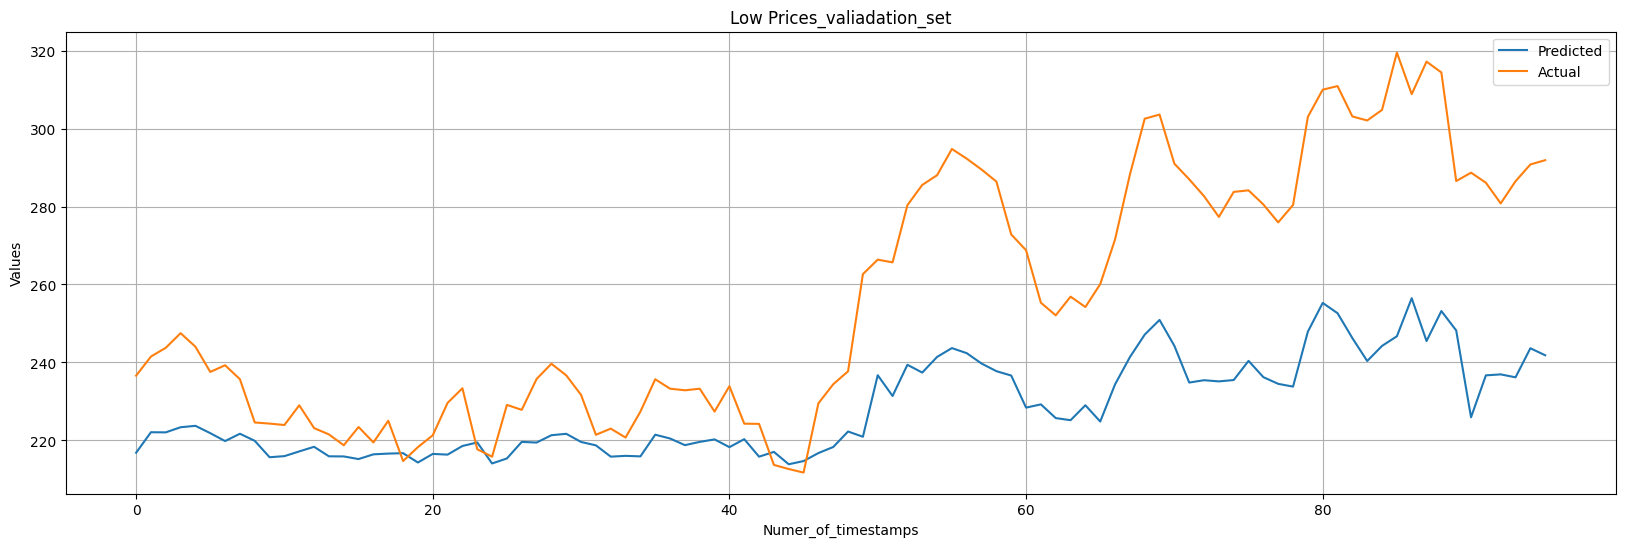

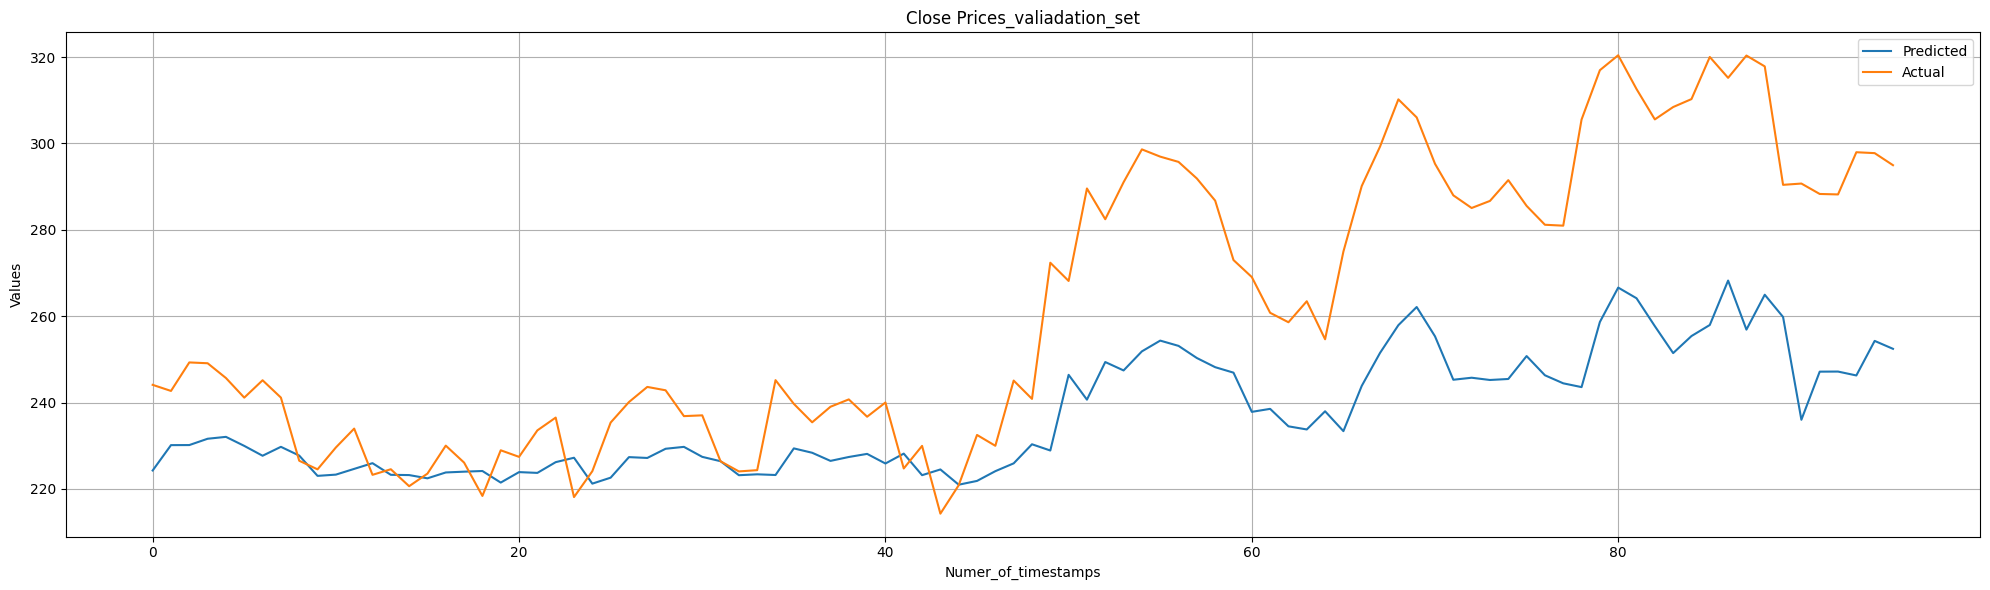

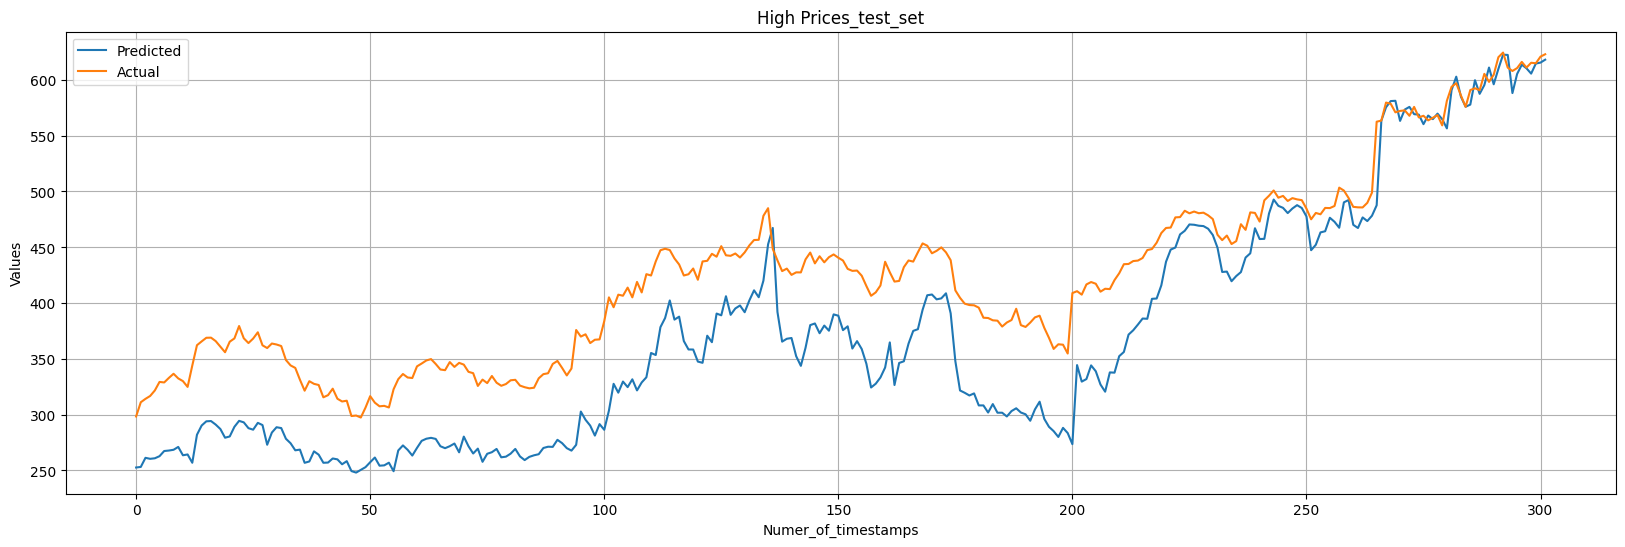

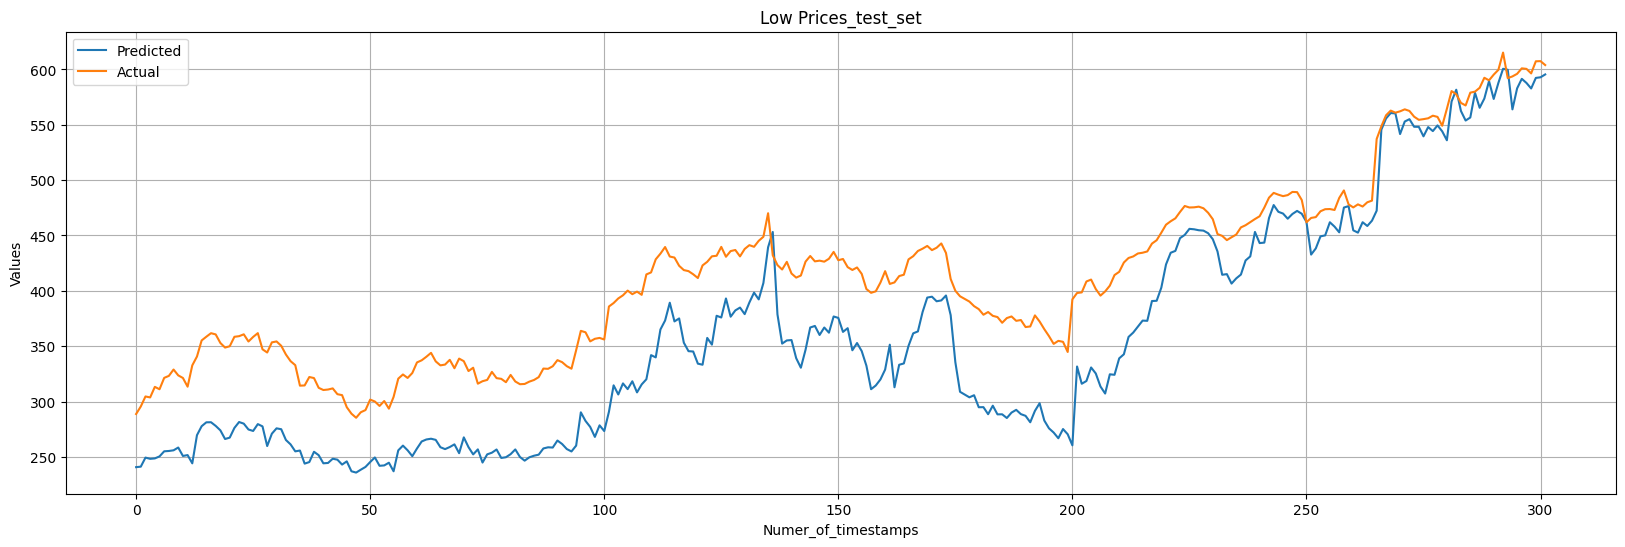

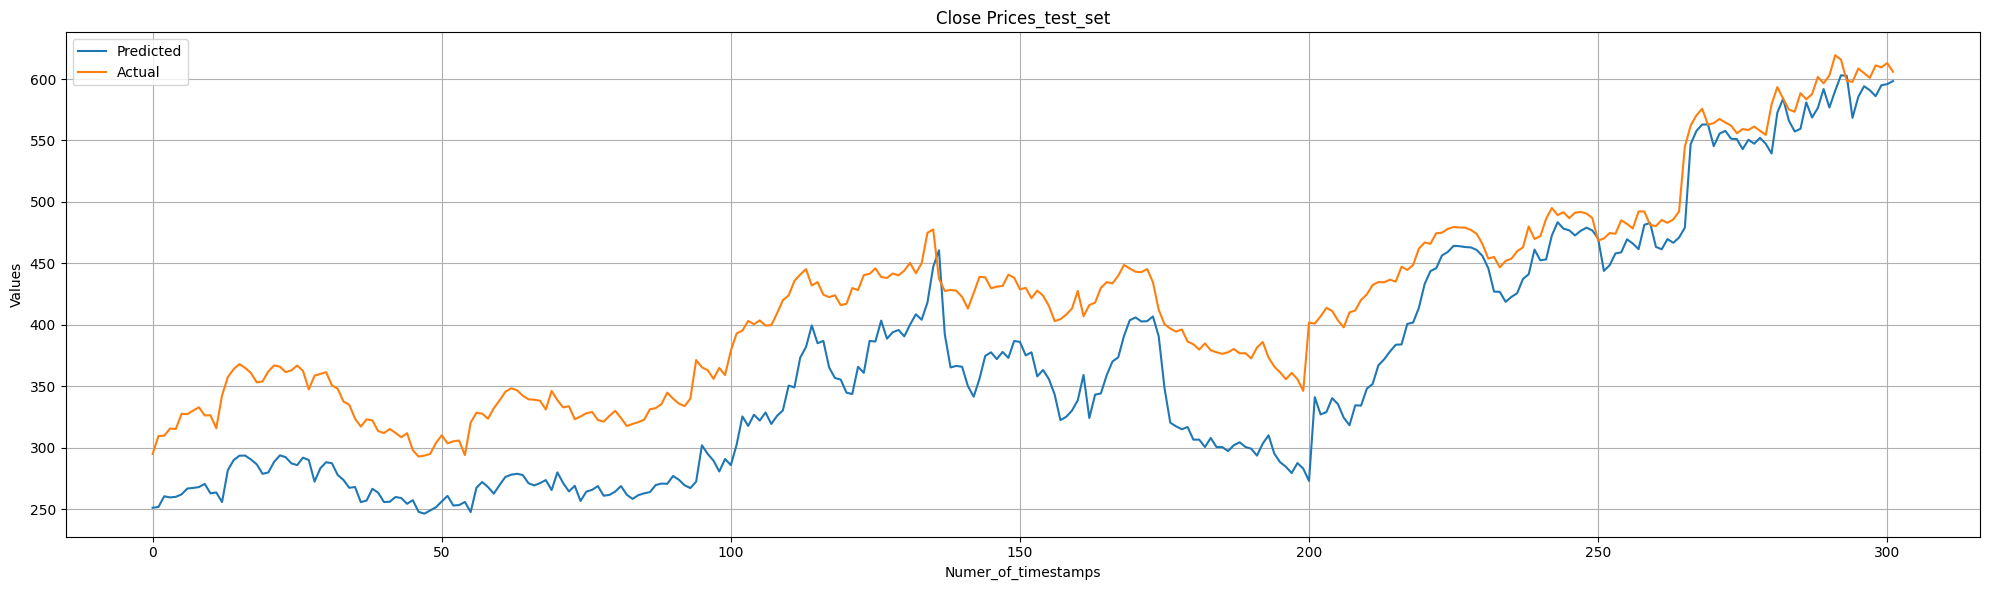

In [13]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Congiguration 1
print("Configuration 1")
training_loop(num_epochs,lr_1,model_gru)

Configuration 2
Epoch  1 MSE:  0.04832344199777725
Epoch  2 MSE:  0.021164711937115502
Epoch  3 MSE:  0.013780648476118462
Epoch  4 MSE:  0.011914342461098893
Epoch  5 MSE:  0.011372008958647291
Epoch  6 MSE:  0.011168112602329517
Epoch  7 MSE:  0.011077825401259251
Epoch  8 MSE:  0.011034825460354497
Epoch  9 MSE:  0.011006789692737736
Epoch  10 MSE:  0.010978414248710724
Epoch  11 MSE:  0.010945946130041895
Epoch  12 MSE:  0.010910649782633586
Epoch  13 MSE:  0.010874793321985385
Epoch  14 MSE:  0.010840139768078152
Epoch  15 MSE:  0.010807677634971733
Epoch  16 MSE:  0.010777371930961538
Epoch  17 MSE:  0.010749829199811446
Epoch  18 MSE:  0.01072473659174318
Epoch  19 MSE:  0.010700994907067326
Epoch  20 MSE:  0.010679390272972591
Epoch  21 MSE:  0.010658484711272448
Epoch  22 MSE:  0.010639293133899871
Epoch  23 MSE:  0.010620234232898698
Epoch  24 MSE:  0.010602383893936826
Epoch  25 MSE:  0.010584179297570058
Epoch  26 MSE:  0.01056646495749039
Epoch  27 MSE:  0.0105475370173689

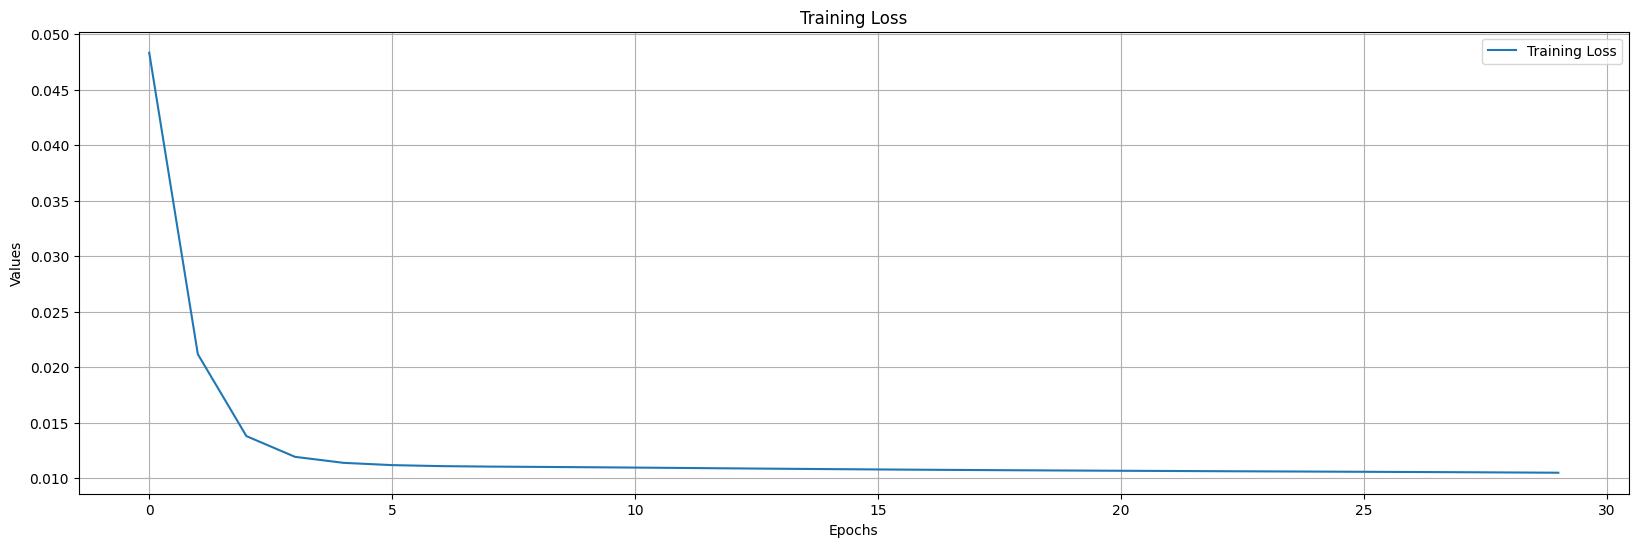

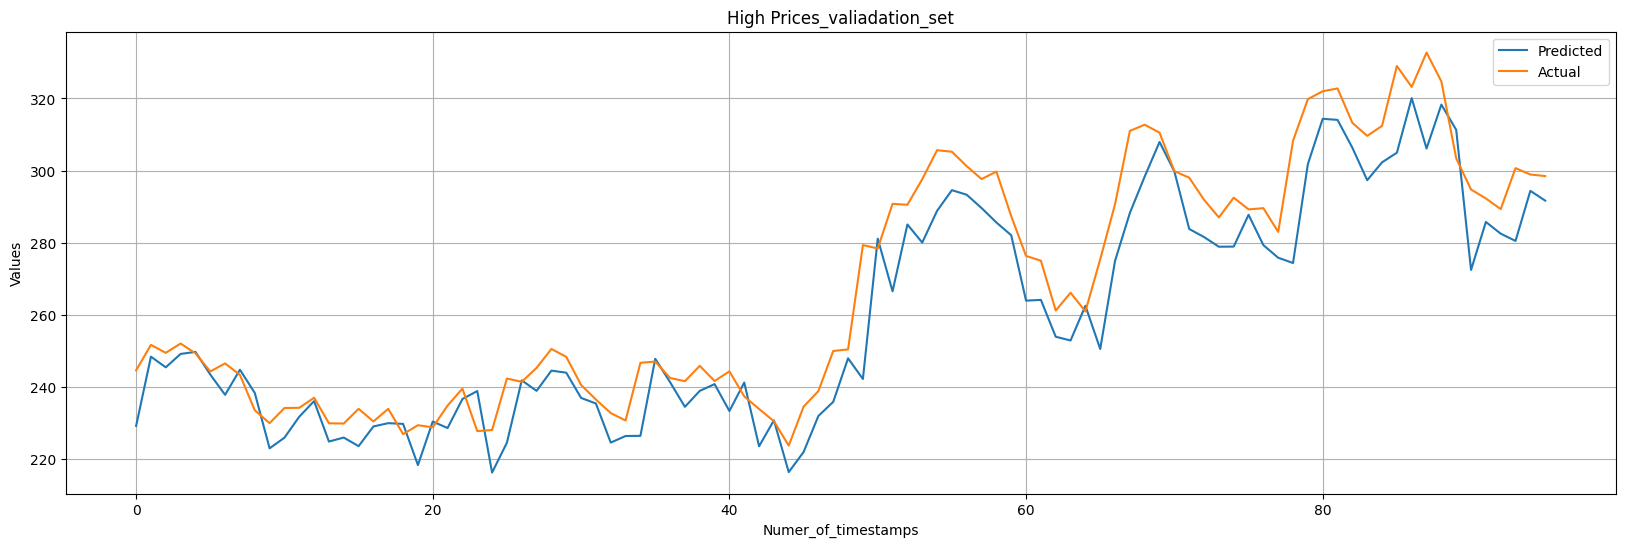

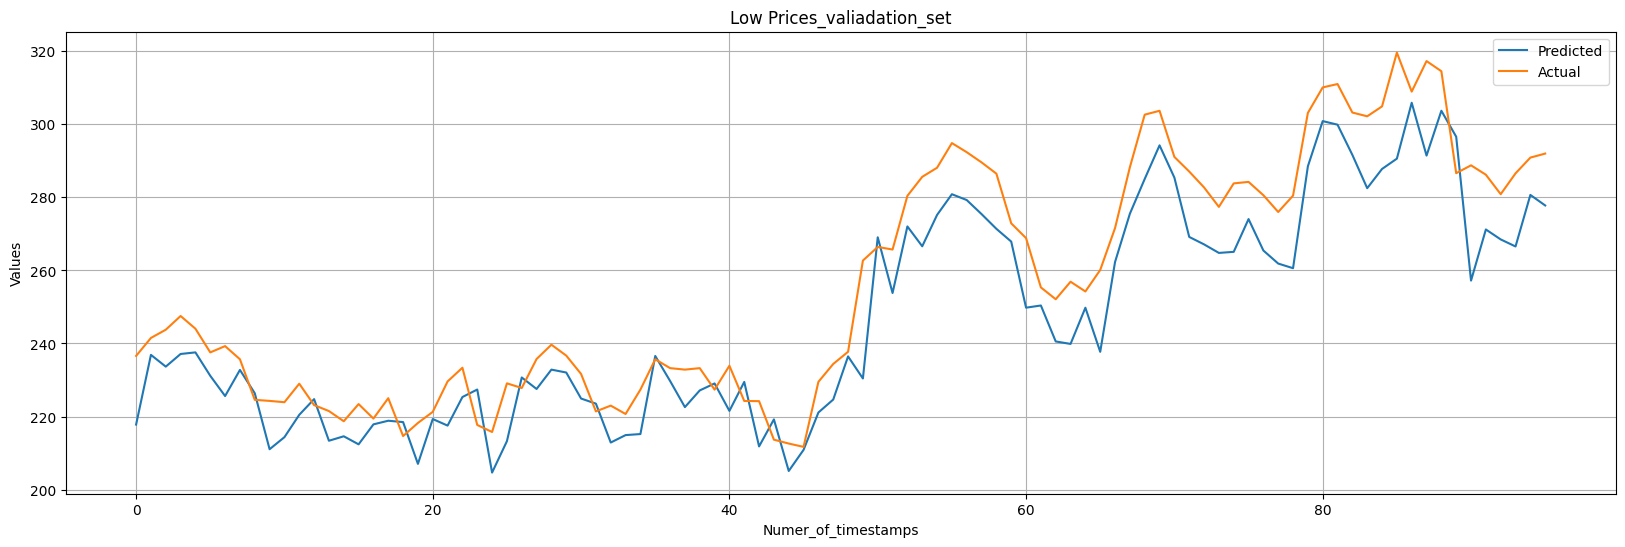

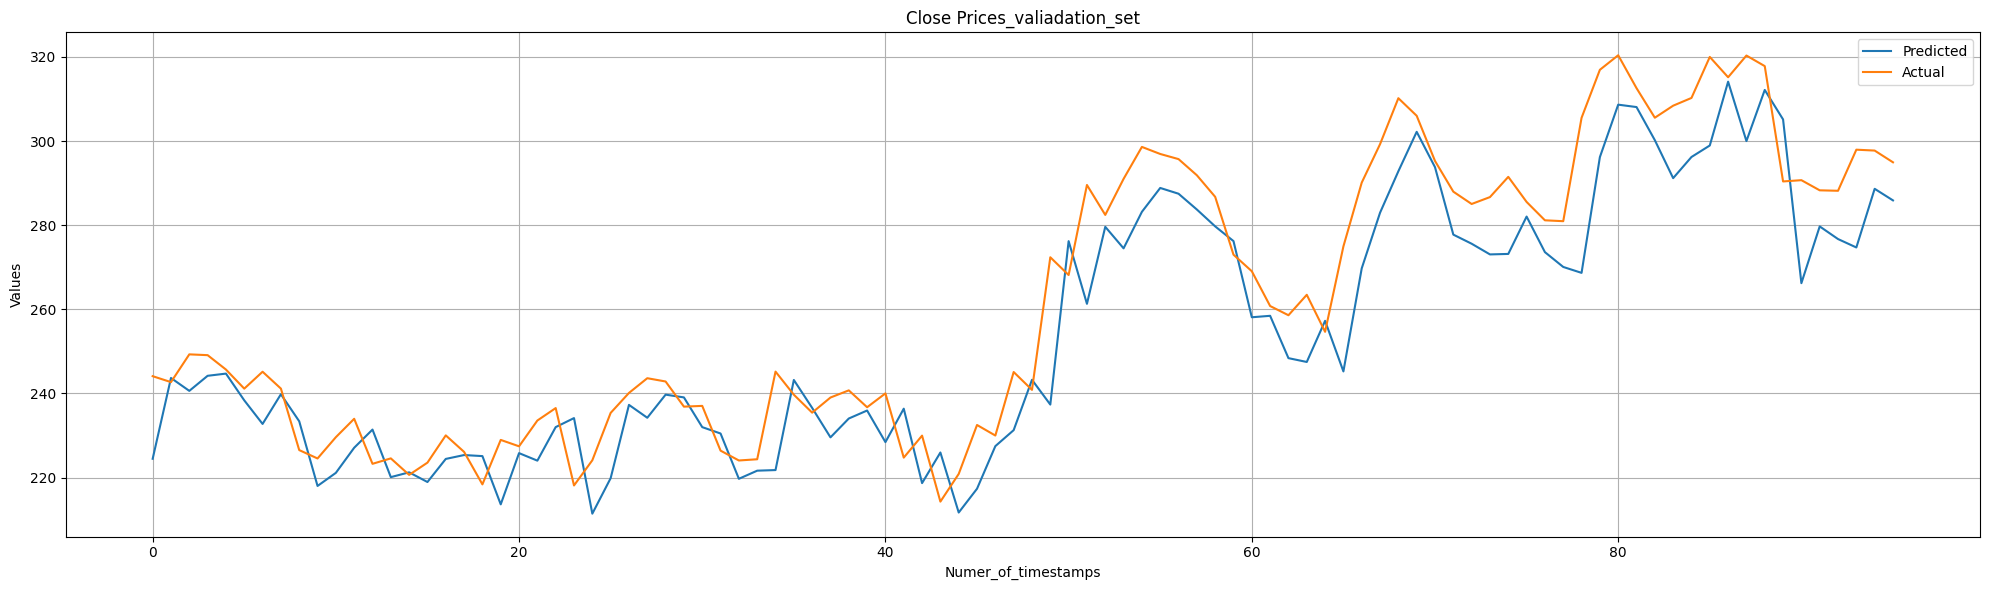

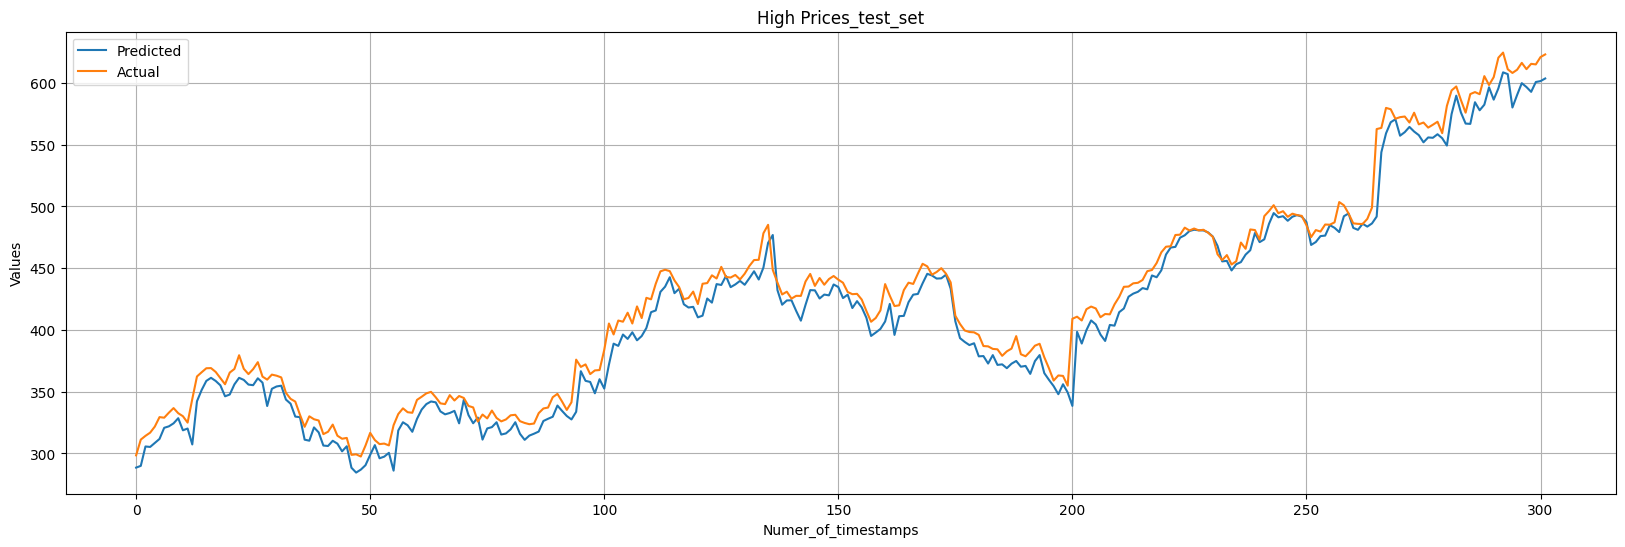

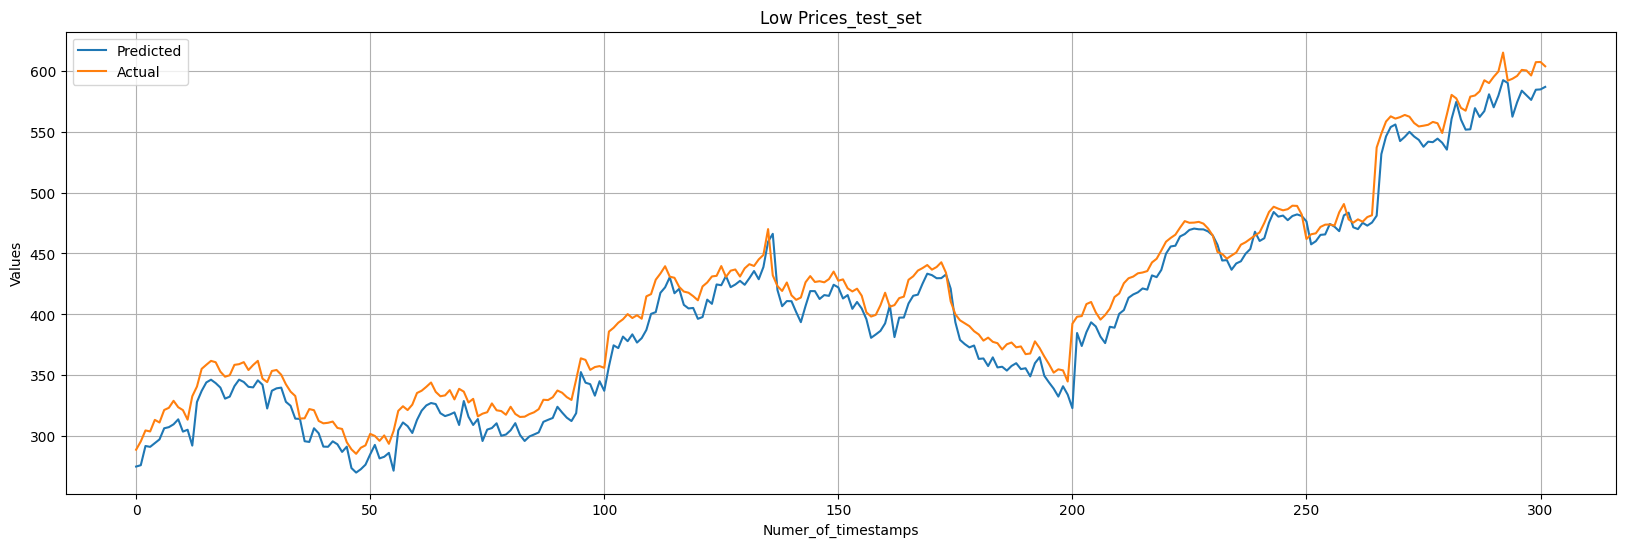

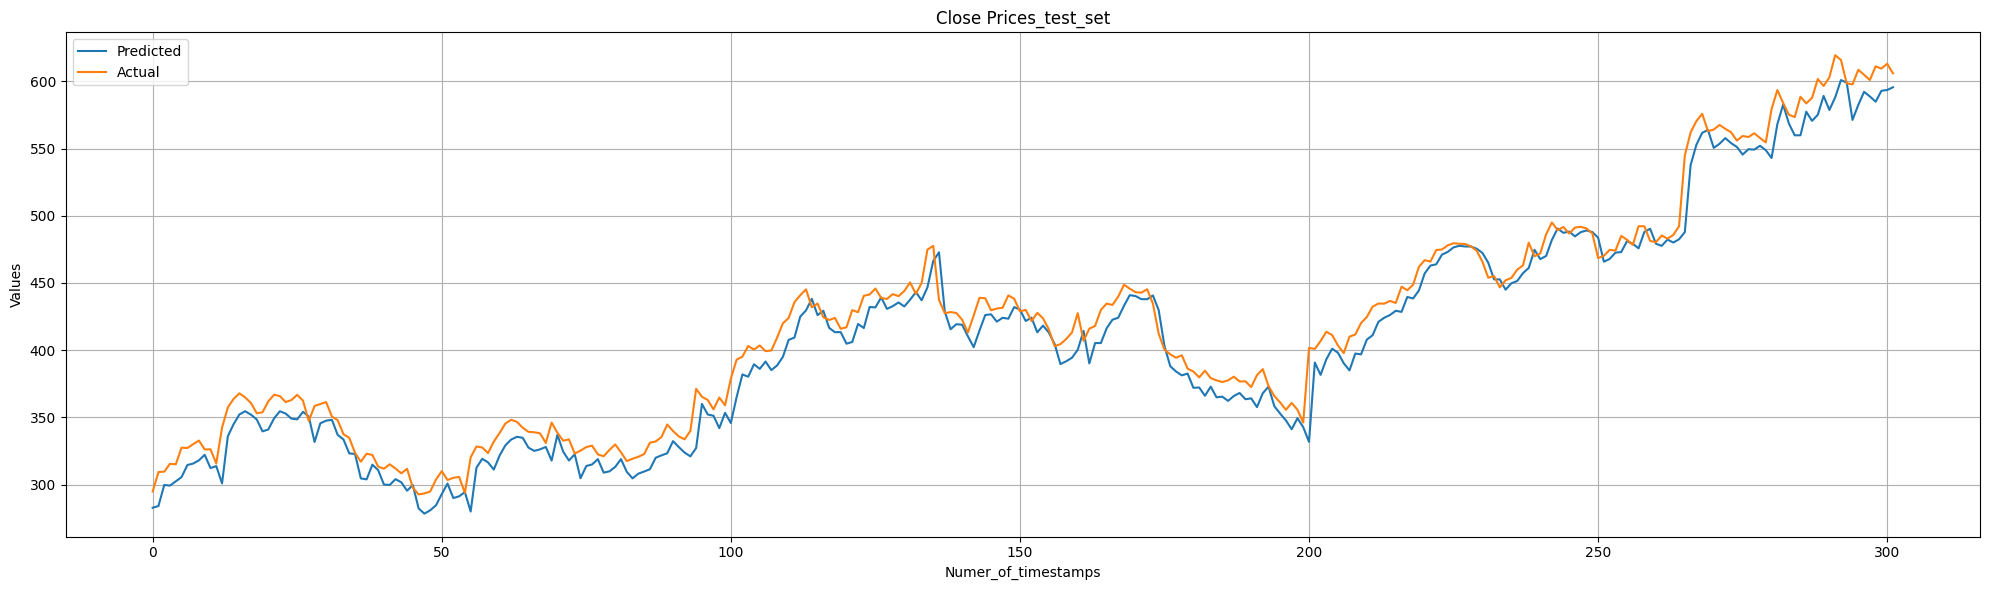

In [14]:
# Congiguration 2
print("Configuration 2")
training_loop(num_epochs,lr_2,model_gru)

### LSTM

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Initialize weight matrices and bias vectors
        self.W_i = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))  # input gate
        self.W_h = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))  # hidden state
        self.b = nn.Parameter(torch.Tensor(hidden_dim * 4))  # bias

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        for i in range(x.size(1)):
            gates = torch.matmul(x[:,i], self.W_i) + torch.matmul(h[-1, :, :], self.W_h) + self.b
            ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            c = forgetgate * c + ingate * cellgate

            h = outgate * torch.tanh(c)

        out = self.fc(h[-1])
        return out

Configuration 1
Epoch  1 MSE:  0.04183657811833026
Epoch  2 MSE:  0.04552733068617607
Epoch  3 MSE:  0.05192478354392306
Epoch  4 MSE:  0.052668294241171046
Epoch  5 MSE:  0.042874338218083015
Epoch  6 MSE:  0.03948452814150999
Epoch  7 MSE:  0.031025065324035414
Epoch  8 MSE:  0.028036952689558806
Epoch  9 MSE:  0.022560132069797293
Epoch  10 MSE:  0.020504601322953314
Epoch  11 MSE:  0.01950830699649865
Epoch  12 MSE:  0.018773240148996763
Epoch  13 MSE:  0.018146980436466606
Epoch  14 MSE:  0.017912671035480263
Epoch  15 MSE:  0.017667686943387013
Epoch  16 MSE:  0.017612526596432823
Epoch  17 MSE:  0.01740731986964322
Epoch  18 MSE:  0.01736097814105295
Epoch  19 MSE:  0.01717298532186467
Epoch  20 MSE:  0.017137510618471692
Epoch  21 MSE:  0.01716124595168977
Epoch  22 MSE:  0.017128710325512705
Epoch  23 MSE:  0.017136718037821408
Epoch  24 MSE:  0.017729183654239096
Epoch  25 MSE:  0.017213212759152583
Epoch  26 MSE:  0.0172407716398041
Epoch  27 MSE:  0.016987310365252504
Epoch

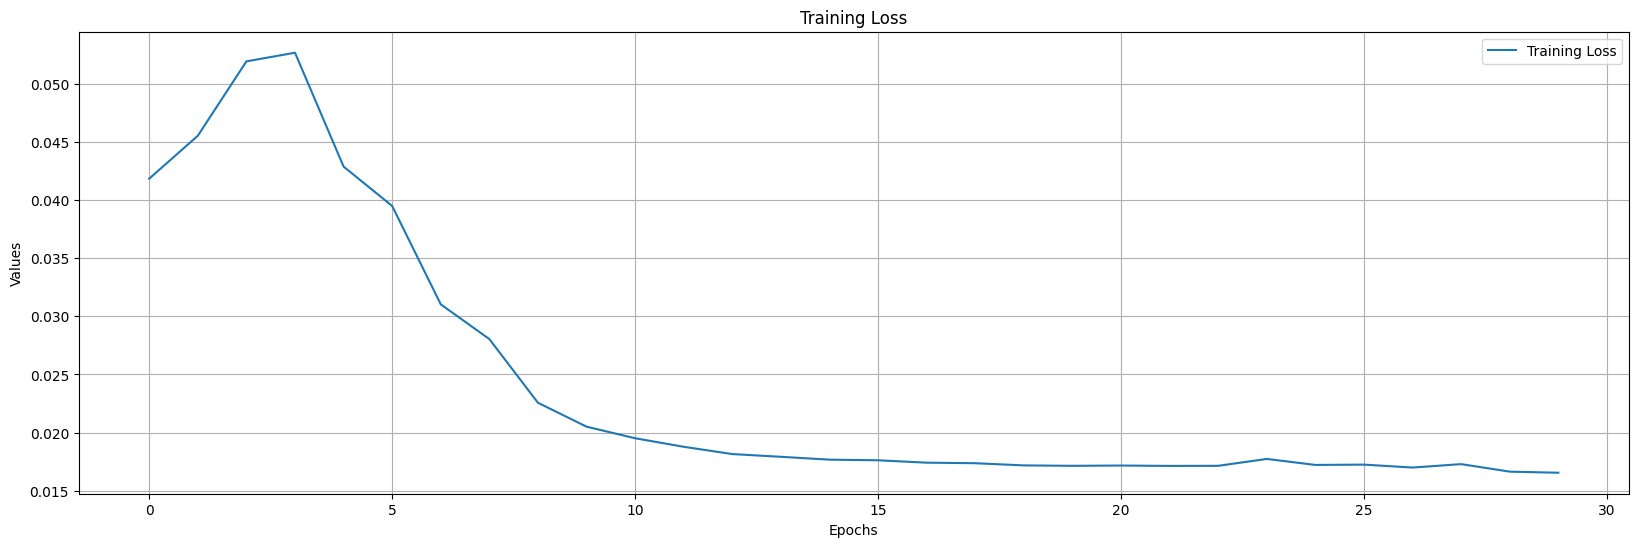

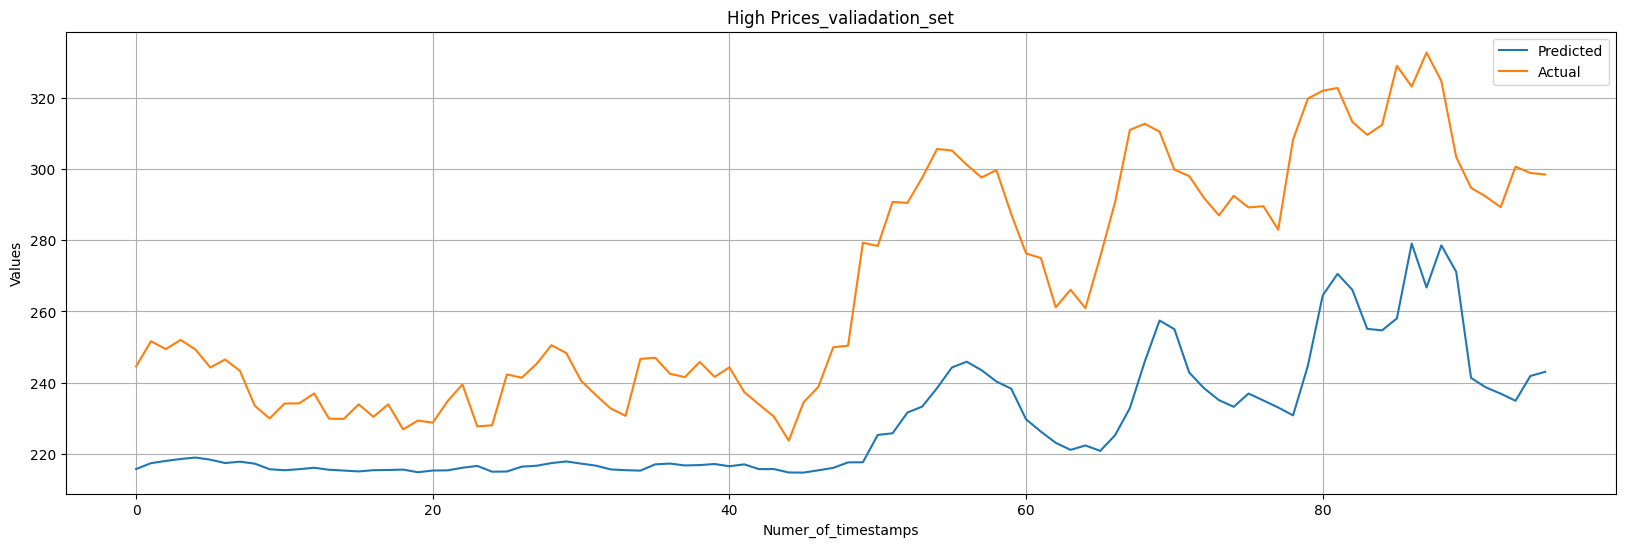

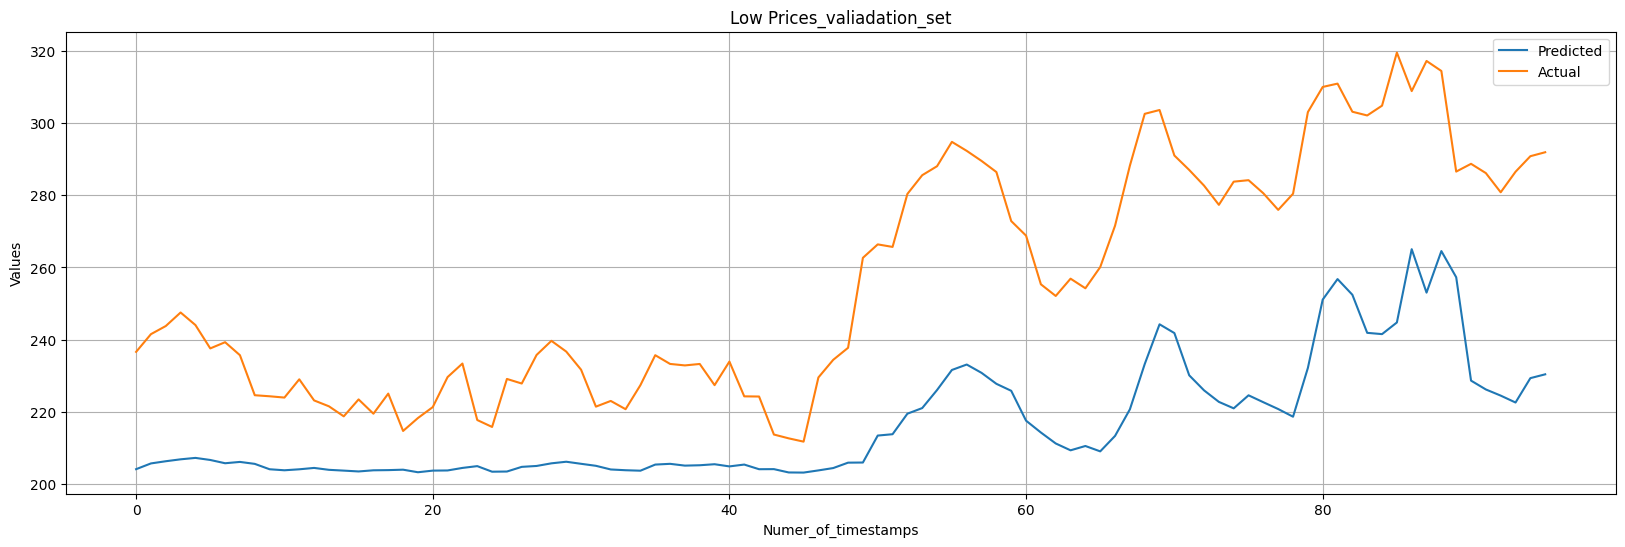

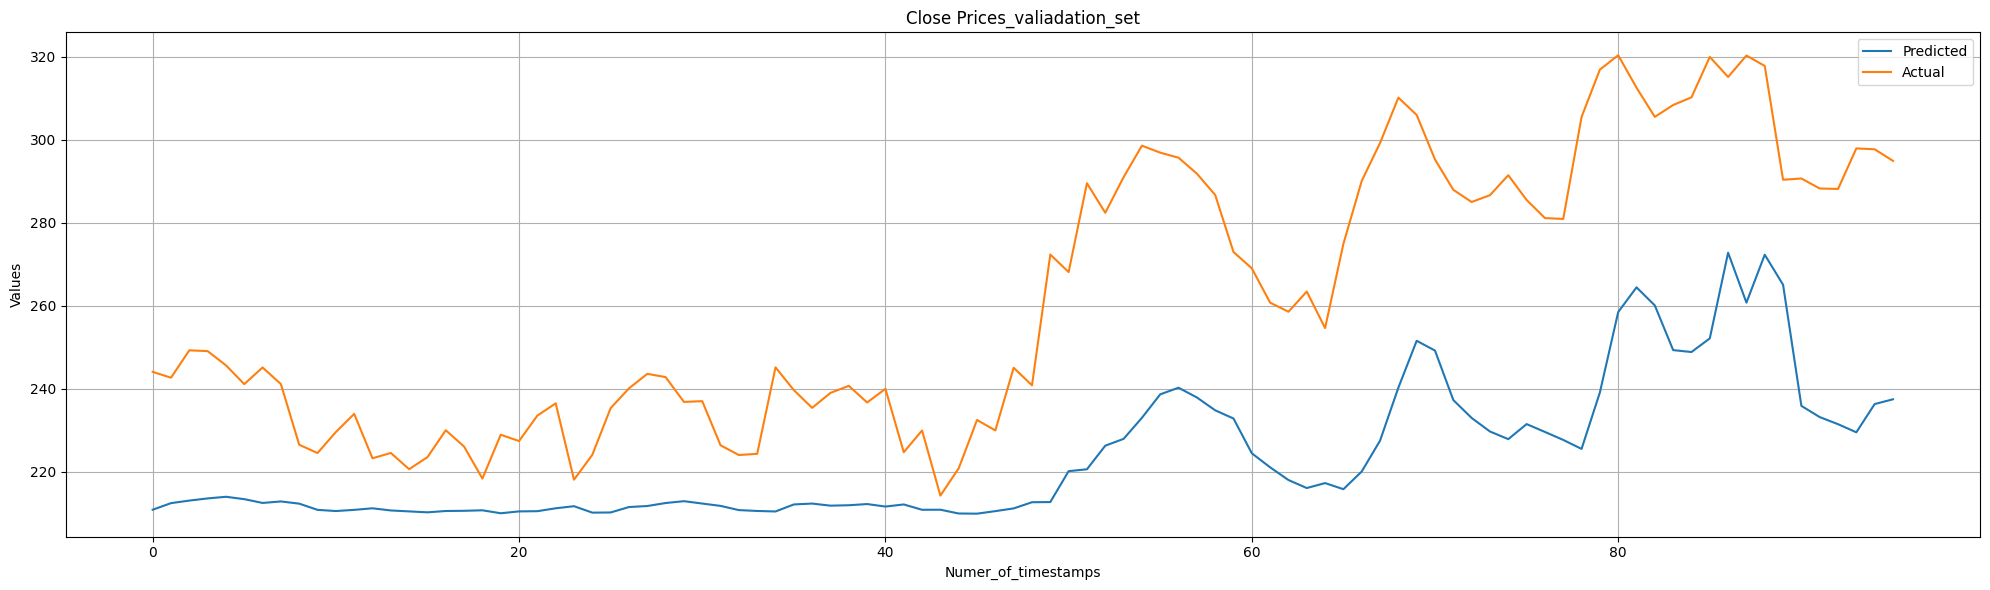

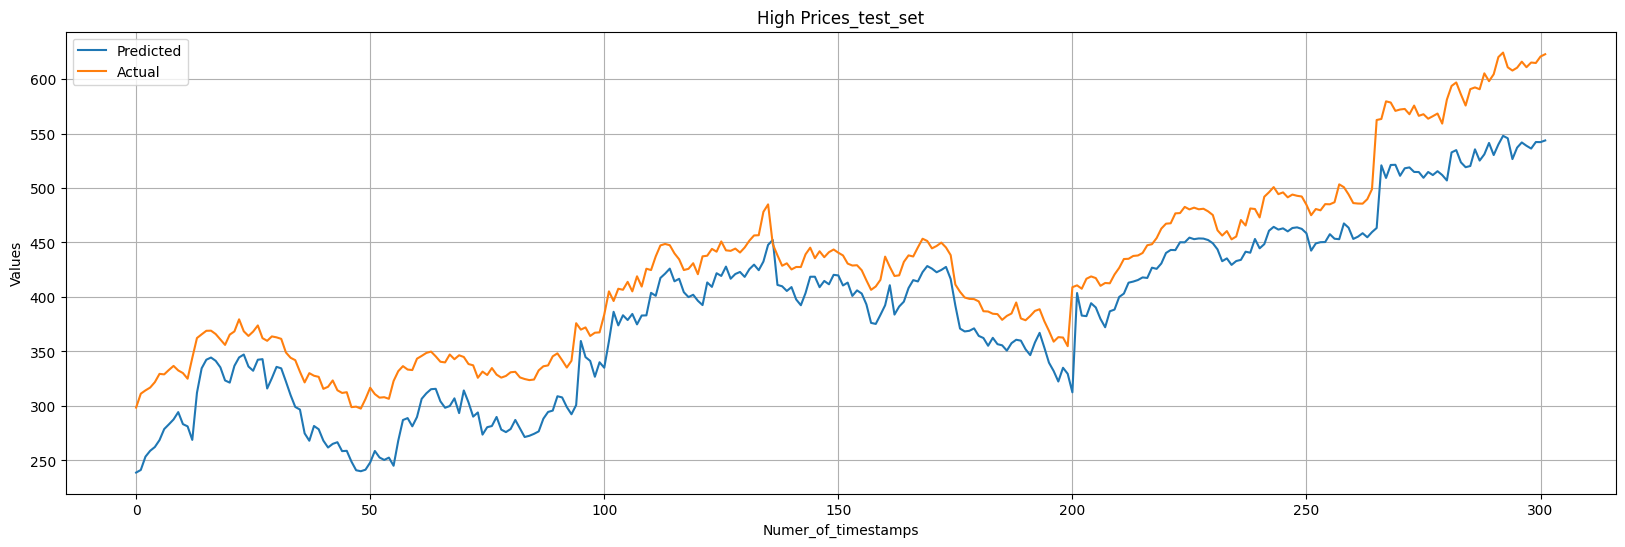

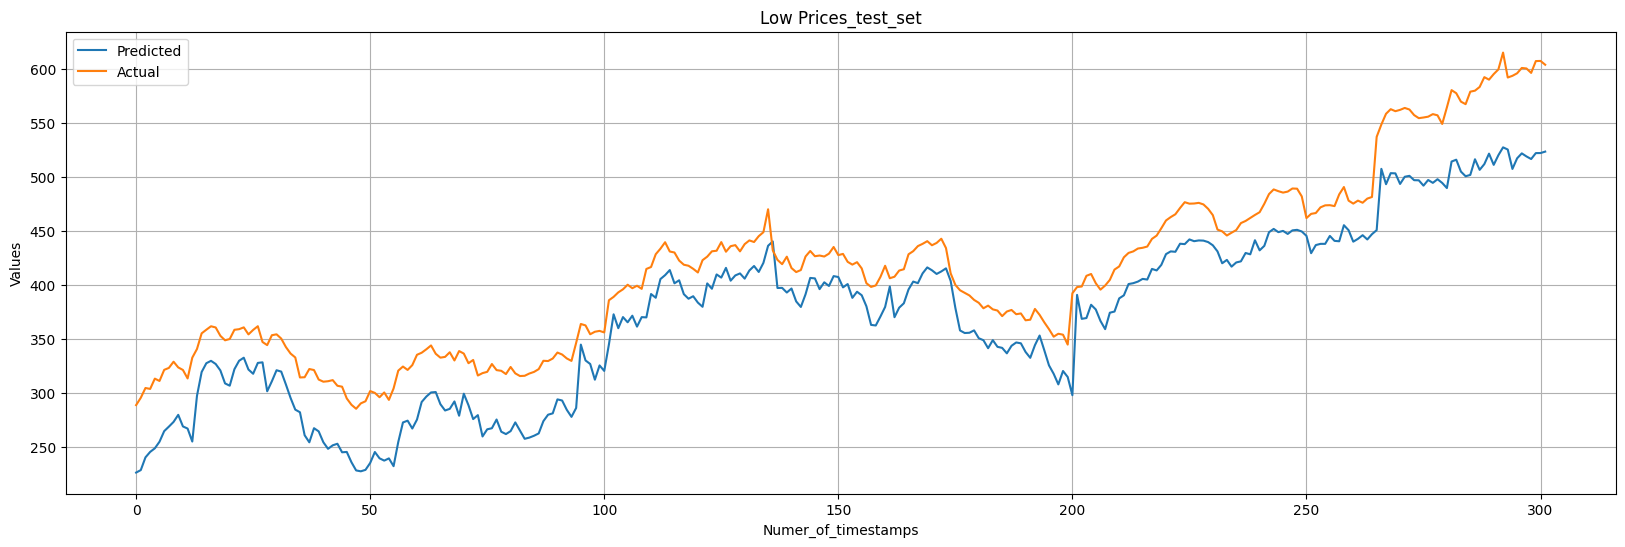

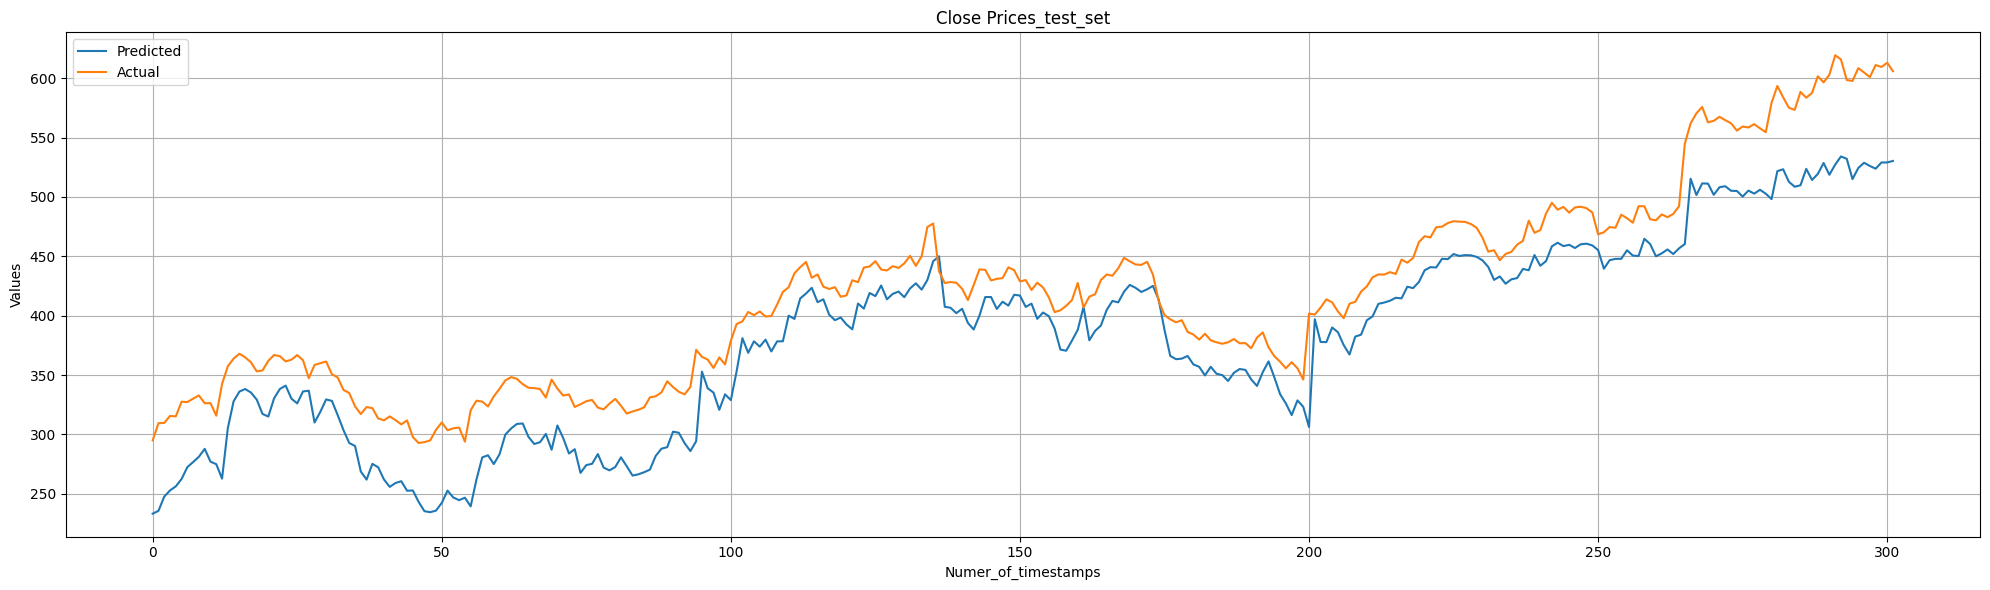

In [16]:
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Congiguration 1
print("Configuration 1")
training_loop(num_epochs,lr_1,model_lstm)

Configuration 2
Epoch  1 MSE:  0.02588900823157141
Epoch  2 MSE:  0.016063147267381672
Epoch  3 MSE:  0.013102098031747833
Epoch  4 MSE:  0.012069256903621546
Epoch  5 MSE:  0.011701949945609769
Epoch  6 MSE:  0.011357907537163042
Epoch  7 MSE:  0.011270766618723954
Epoch  8 MSE:  0.011048144886902587
Epoch  9 MSE:  0.011002790328531175
Epoch  10 MSE:  0.010847186807633085
Epoch  11 MSE:  0.010810064283961288
Epoch  12 MSE:  0.010696861672499072
Epoch  13 MSE:  0.010660421585774831
Epoch  14 MSE:  0.010576253513447483
Epoch  15 MSE:  0.01053863595345759
Epoch  16 MSE:  0.010475065281005166
Epoch  17 MSE:  0.010437162739331967
Epoch  18 MSE:  0.010387580404572177
Epoch  19 MSE:  0.010350997974837321
Epoch  20 MSE:  0.010310344204934142
Epoch  21 MSE:  0.010275937233412047
Epoch  22 MSE:  0.010240619405949291
Epoch  23 MSE:  0.010208096096070124
Epoch  24 MSE:  0.010175652307060584
Epoch  25 MSE:  0.010144436577723312
Epoch  26 MSE:  0.010113866363350868
Epoch  27 MSE:  0.010084535992895

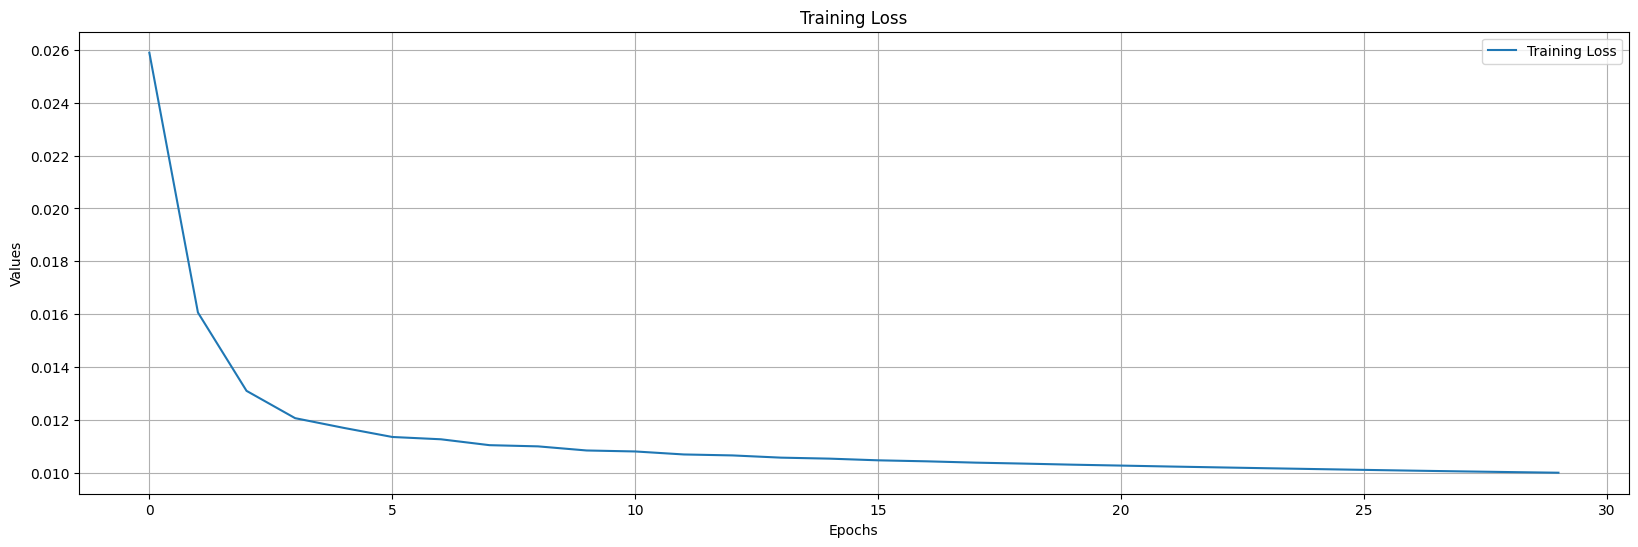

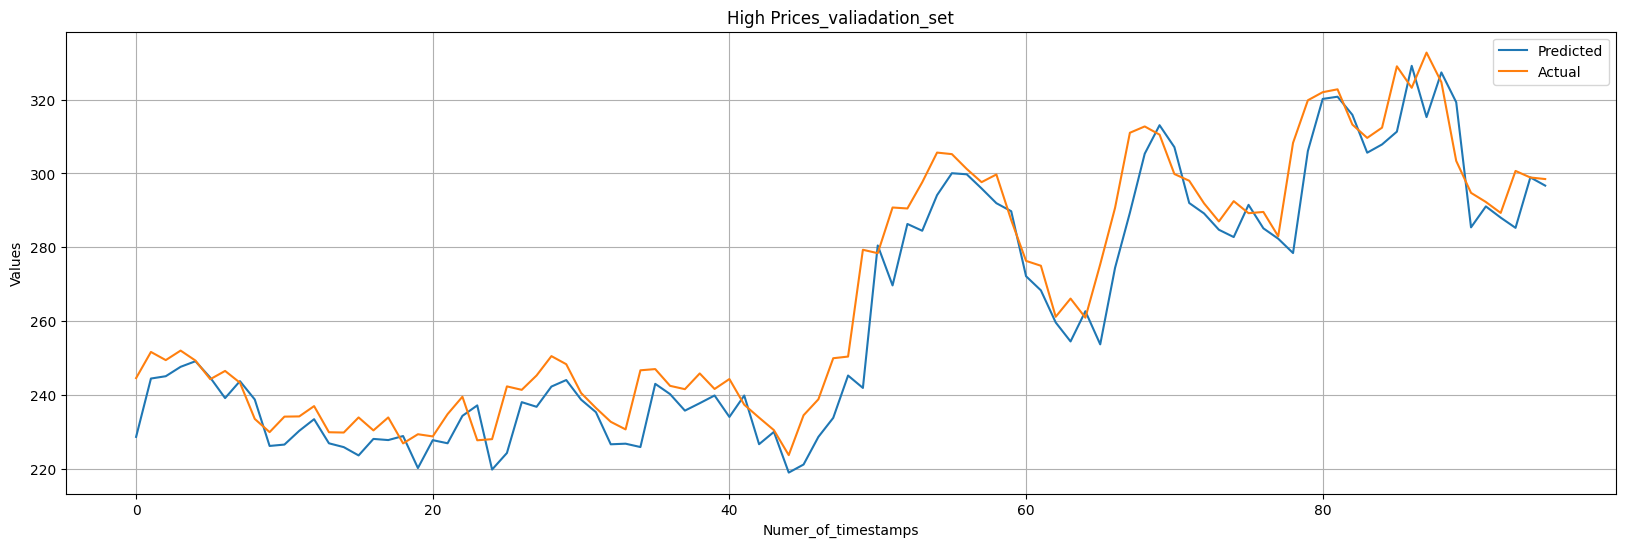

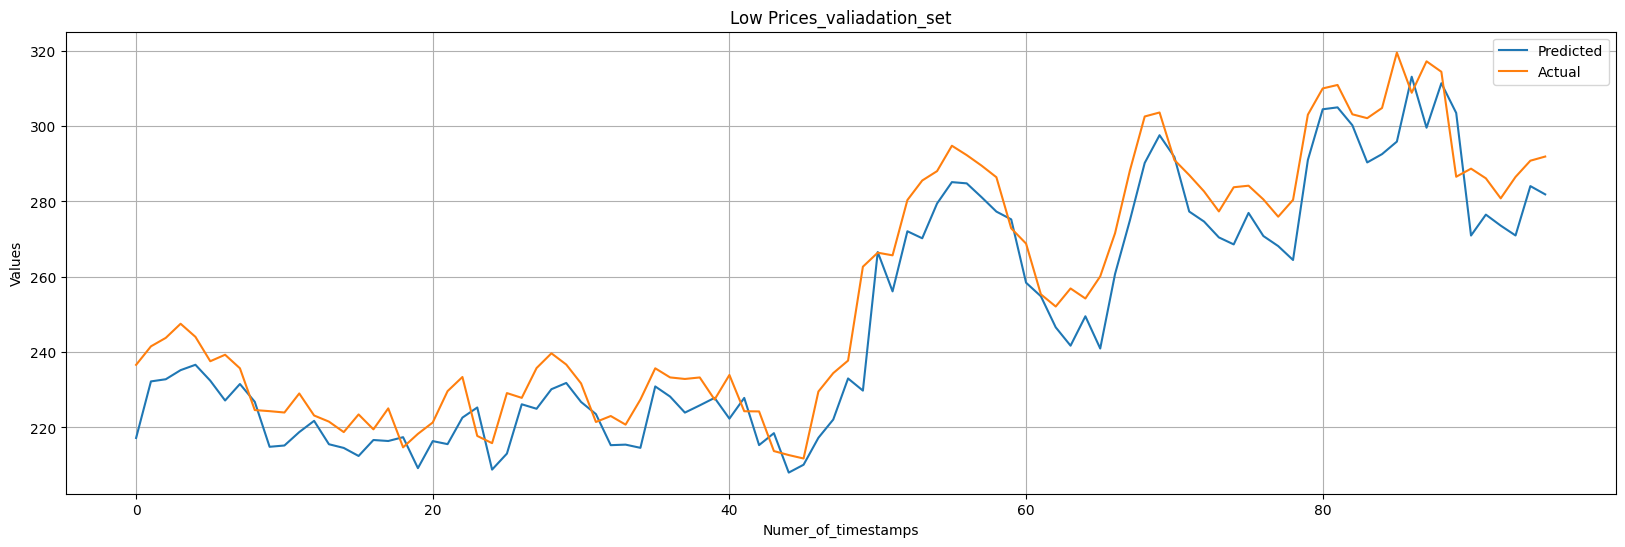

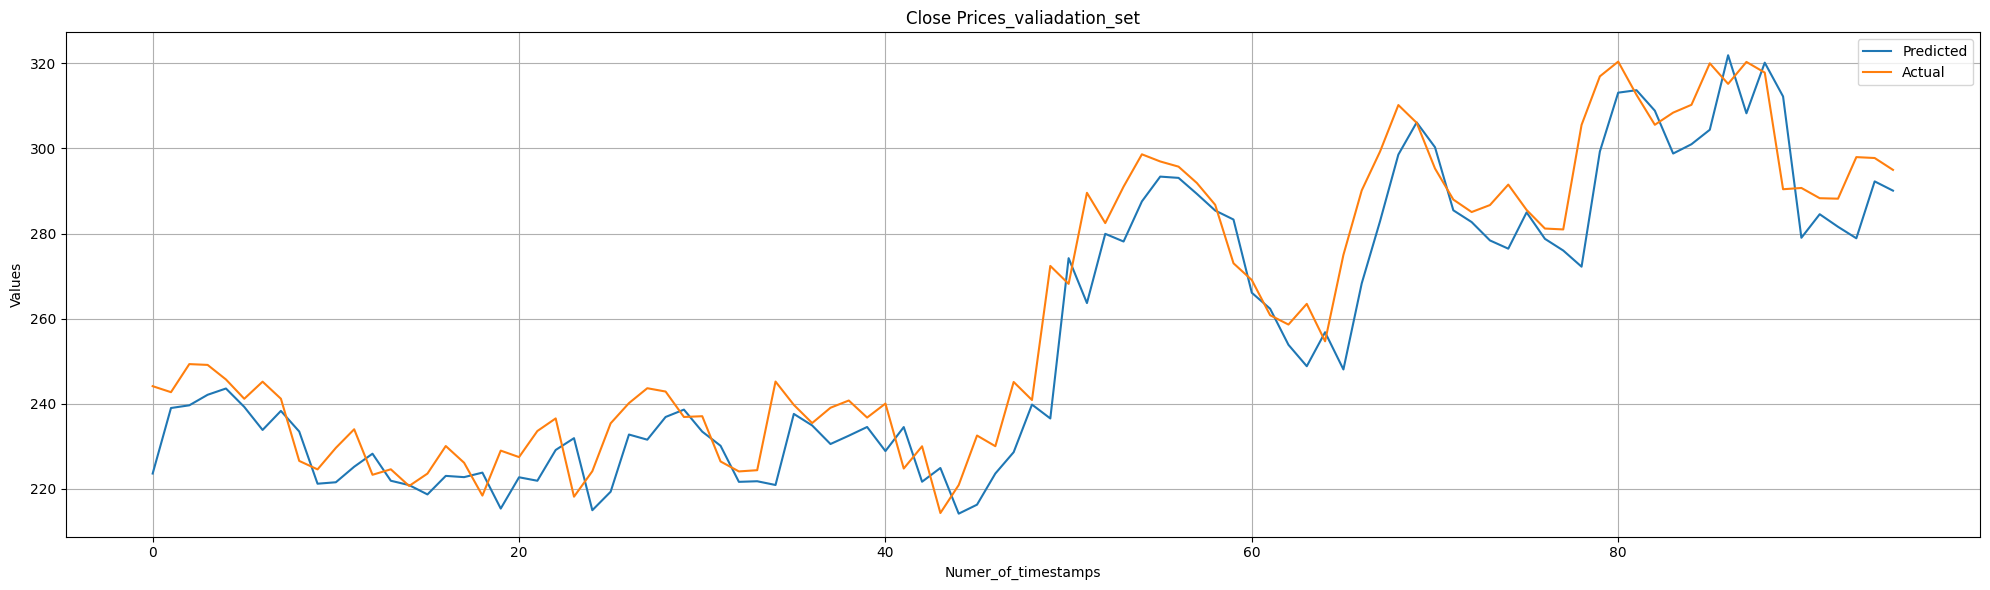

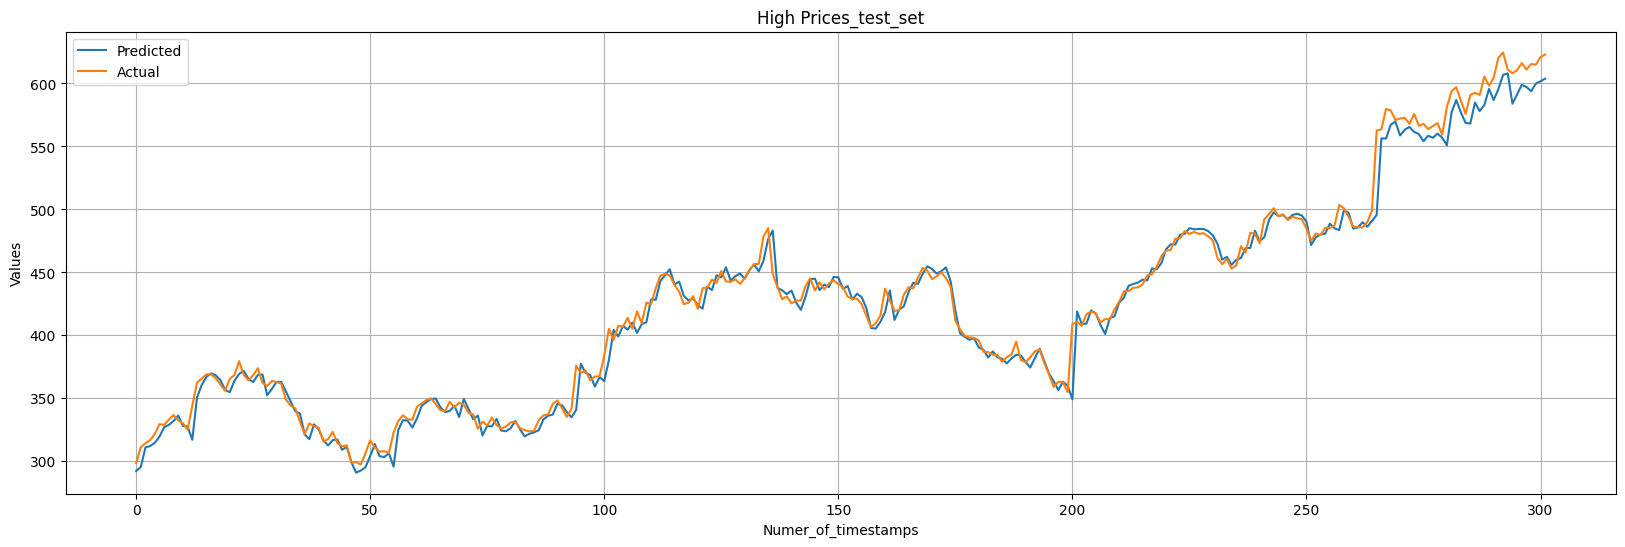

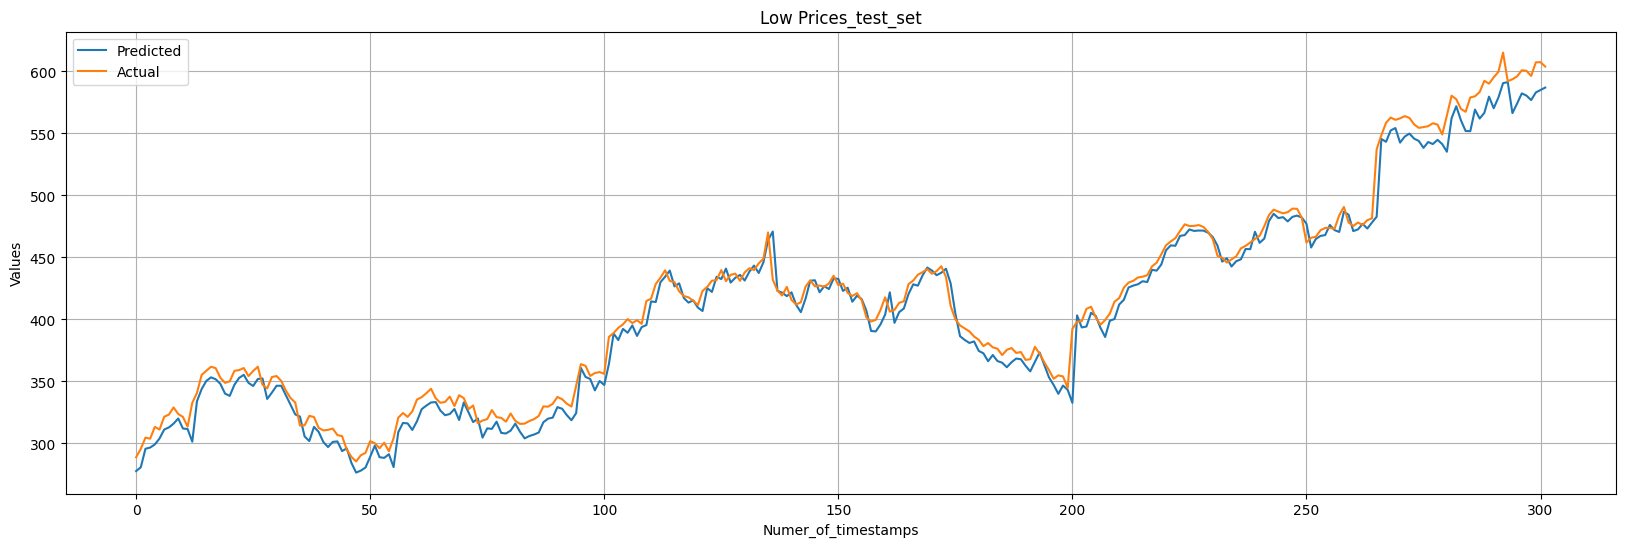

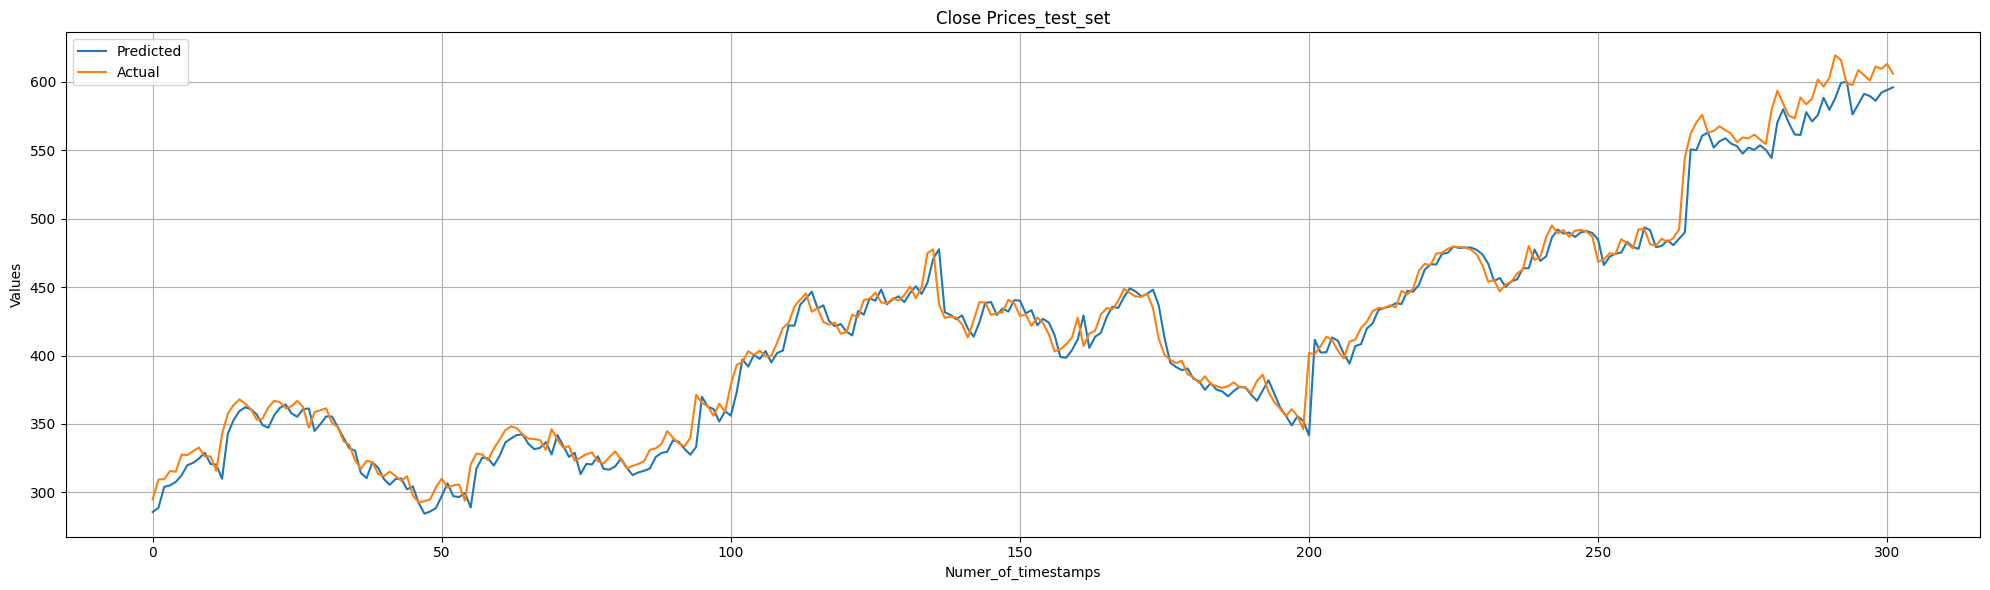

In [17]:
# Congiguration 2
print("Configuration 2")
training_loop(num_epochs,lr_2,model_lstm)